<a href="https://colab.research.google.com/github/samirp92/Final-Year-Project-Time-Series-Forecasting-/blob/LSTM/LSTM_Best_sequence_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the required libraries

In [1]:
# Disable warnings in the notebook for maintaining clean output
import warnings
warnings.filterwarnings('ignore')

# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
# Mount the google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Set the root path directory
root_path = "/content/drive/MyDrive/Final Year Project"

Mounted at /content/drive


# Data Loading

In [3]:
# Load the data from google drive
df = pd.read_csv("/content/drive/MyDrive/Final Year Project/household_power_consumption.txt", sep=';')
df

Date      Time Global_active_power Global_reactive_power  \
0        16/12/2006  17:24:00               4.216                 0.418   
1        16/12/2006  17:25:00               5.360                 0.436   
2        16/12/2006  17:26:00               5.374                 0.498   
3        16/12/2006  17:27:00               5.388                 0.502   
4        16/12/2006  17:28:00               3.666                 0.528   
...             ...       ...                 ...                   ...   
2075254  26/11/2010  20:58:00               0.946                   0.0   
2075255  26/11/2010  20:59:00               0.944                   0.0   
2075256  26/11/2010  21:00:00               0.938                   0.0   
2075257  26/11/2010  21:01:00               0.934                   0.0   
2075258  26/11/2010  21:02:00               0.932                   0.0   

         Voltage Global_intensity Sub_metering_1 Sub_metering_2  \
0        234.840           18.400          0.000          1.000   
1        233.630           23.000          0.000          1.000   
2        233.290           23.000          0.000          2.000   
3        233.740           23.000          0.000          1.000   
4        235.680           15.800          0.000          1.000   
...          ...              ...            ...            ...   
2075254   240.43              4.0            0.0            0.0   
2075255    240.0              4.0            0.0            0.0   
2075256   239.82              3.8            0.0            0.0   
2075257    239.7              3.8            0.0            0.0   
2075258   239.55              3.8            0.0            0.0   

         Sub_metering_3  
0                  17.0  
1                  16.0  
2                  17.0  
3                  17.0  
4                  17.0  
...                 ...  
2075254             0.0  
2075255             0.0  
2075256             0.0  
2075257             0.0  
2075258             0.0  

[2075259 rows x 9 columns]

# Data Preprocessing

In [4]:
# Replace '?' with NaN values
df.replace('?', np.nan, inplace=True)

In [5]:
# Convert numeric columns to appropriate data types
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')

# Confirm the updated data types
print(df.dtypes)

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


In [6]:
# Check Missing Values
df.isnull().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [7]:
# Convert the 'Date' and 'Time' columns to a single 'date_time' column
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Convert the 'date_time' column to datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Set the 'date_time' column as the index
df.set_index('date_time', inplace=True)

# Drop the original 'Date' and 'Time' columns
df.drop(columns=['Date', 'Time'], inplace=True)

# Copy the original DataFrame into a new DataFrame
df_copy = df.copy()
df_copy

Global_active_power  Global_reactive_power  Voltage  \
date_time                                                                  
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
date_time                                                               
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   
...                               ...             ...             ...   
2010-11-26 20:58:00               4.0             0.0             0.0   
2010-11-26 20:59:00               4.0             0.0             0.0   
2010-11-26 21:00:00               3.8             0.0             0.0   
2010-11-26 21:01:00               3.8             0.0             0.0   
2010-11-26 21:02:00               3.8             0.0             0.0   

                     Sub_metering_3  
date_time                            
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0  
...                             ...  
2010-11-26 20:58:00             0.0  
2010-11-26 20:59:00             0.0  
2010-11-26 21:00:00             0.0  
2010-11-26 21:01:00             0.0  
2010-11-26 21:02:00             0.0  

[2075259 rows x 7 columns]

# Data Imputation

In [8]:
# Check Missing Values
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [9]:
# Apply MICE imputer
imputer = IterativeImputer(random_state=0)
df_imputed = imputer.fit_transform(df)

# Convert back to DataFrame
df_imputed = pd.DataFrame(df_imputed, index=df.index, columns=df.columns)

# Save the DataFrame to an Excel file
df_imputed.to_csv('df_imputed.csv')

In [10]:
# Check Missing Values after imputation
df_imputed.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Note:-

(Global_active_power*1000/60 - Sub_metering_1 - Sub_metering_2 - Sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3

In [11]:
# Creating new variable for remaining power consumption in watt hour
equation1 = (df_imputed['Global_active_power']*1000/60)
equation2 = df_imputed['Sub_metering_1'] + df_imputed['Sub_metering_2'] + df_imputed['Sub_metering_3']
df_imputed['Sub_metering_4'] = equation1 - equation2
df_imputed

Global_active_power  Global_reactive_power  Voltage  \
date_time                                                                  
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
date_time                                                               
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   
...                               ...             ...             ...   
2010-11-26 20:58:00               4.0             0.0             0.0   
2010-11-26 20:59:00               4.0             0.0             0.0   
2010-11-26 21:00:00               3.8             0.0             0.0   
2010-11-26 21:01:00               3.8             0.0             0.0   
2010-11-26 21:02:00               3.8             0.0             0.0   

                     Sub_metering_3  Sub_metering_4  
date_time                                            
2006-12-16 17:24:00            17.0       52.266667  
2006-12-16 17:25:00            16.0       72.333333  
2006-12-16 17:26:00            17.0       70.566667  
2006-12-16 17:27:00            17.0       71.800000  
2006-12-16 17:28:00            17.0       43.100000  
...                             ...             ...  
2010-11-26 20:58:00             0.0       15.766667  
2010-11-26 20:59:00             0.0       15.733333  
2010-11-26 21:00:00             0.0       15.633333  
2010-11-26 21:01:00             0.0       15.566667  
2010-11-26 21:02:00             0.0       15.533333  

[2075259 rows x 8 columns]

# Hourly resampled data

In [12]:
# Resampled the data
hourly_resampled = df_imputed.resample('H').mean()
daily_resampled = df_imputed.resample('D').mean()

## EDA

In [14]:
# Define a function to plot the visualization, distribution and correlation of resampled data
def df_visu_dist_corr(dataset, resample_type, title):

  # Resample the data
  df_resampled = dataset.resample(resample_type).mean()

  print('Shape after %s resampling of data : %s ' %(title, df_resampled.shape))

  # Plot Resampled Data set
  df_resampled.plot(subplots=True, figsize=(30,20))
  plt.suptitle("Visualization of %s resampled Data" %title, fontsize=30, color='blue')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

  # Plot distribution
  print(' \n\n************************************************ %s Resampled distribution Plot **************************************************' %title, end="\n\n")
  df_resampled.hist(figsize=(15, 10), bins=50)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(300)
  plt.show()

  # Plot correlation plot
  print(' \n\n************************************************ Correlation Plot for %s Resampled Data **************************************************' %title, end="\n\n")
  plt.figure(figsize=(10,6))
  sns.heatmap(df_imputed.corr(), annot=True, cmap='coolwarm', fmt='.2f')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(200)
  plt.show()

Shape after Hourly resampling of data : (34589, 8) 


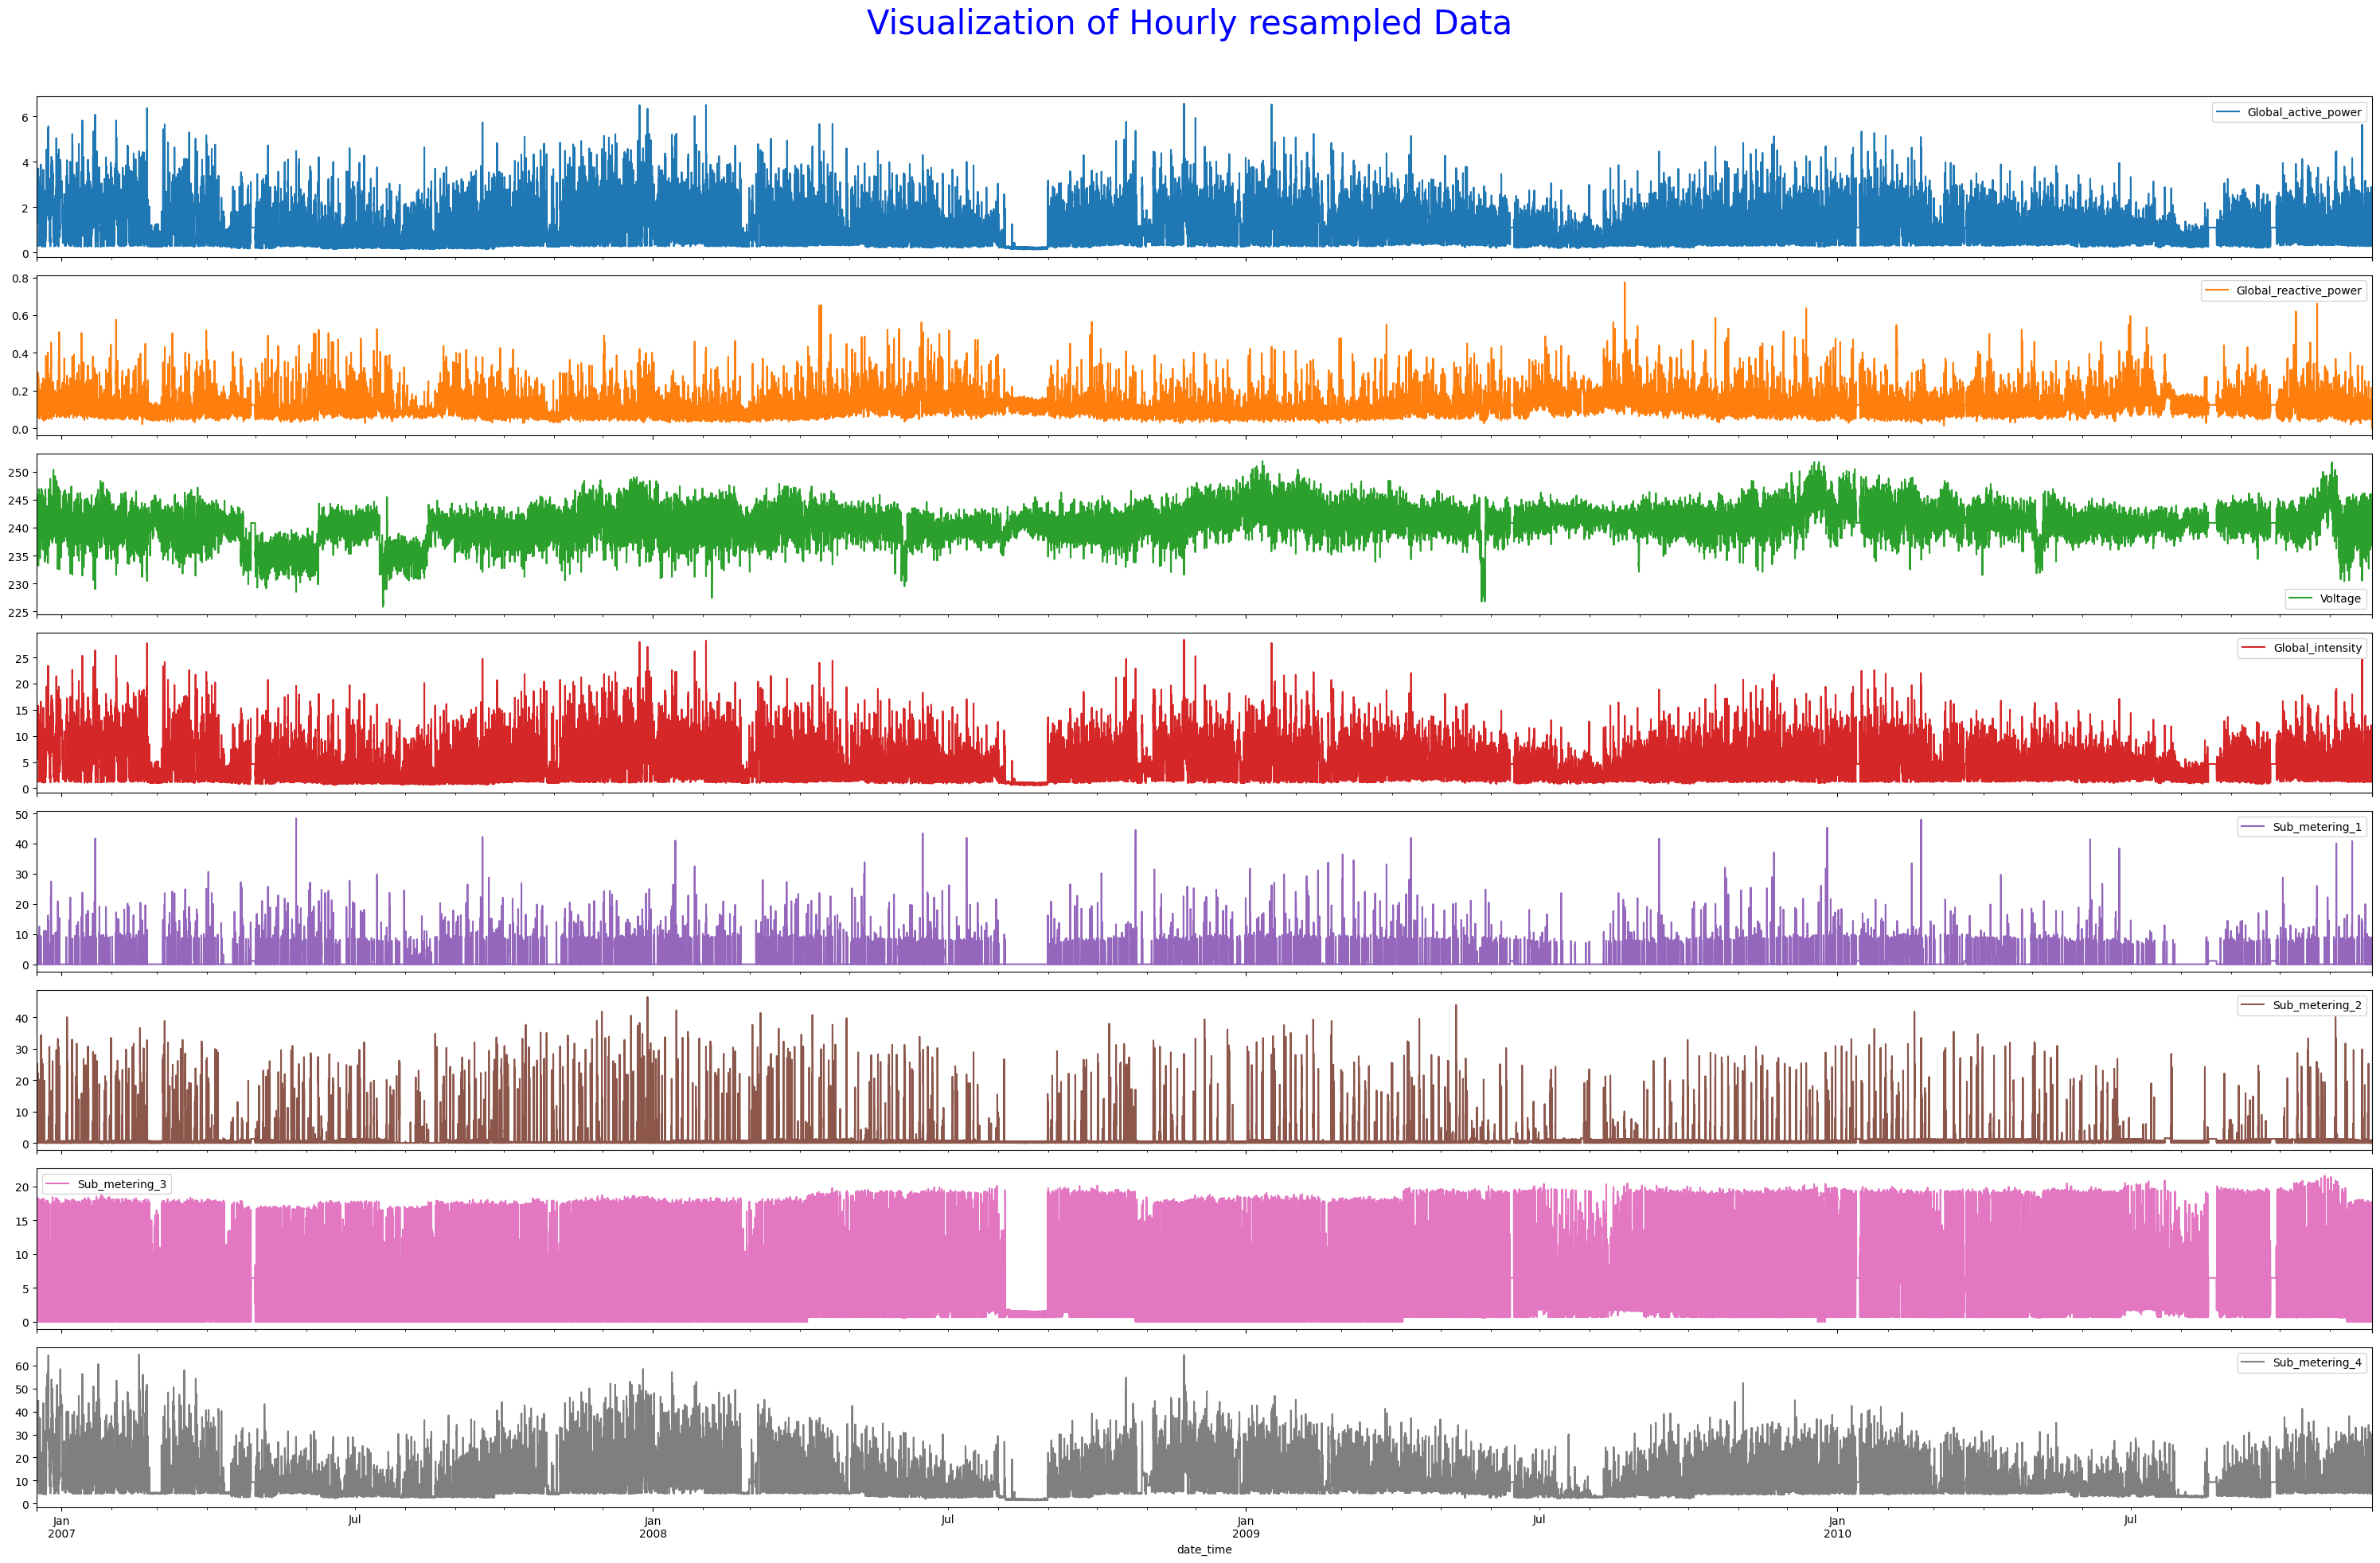

 

************************************************ Hourly Resampled distribution Plot **************************************************



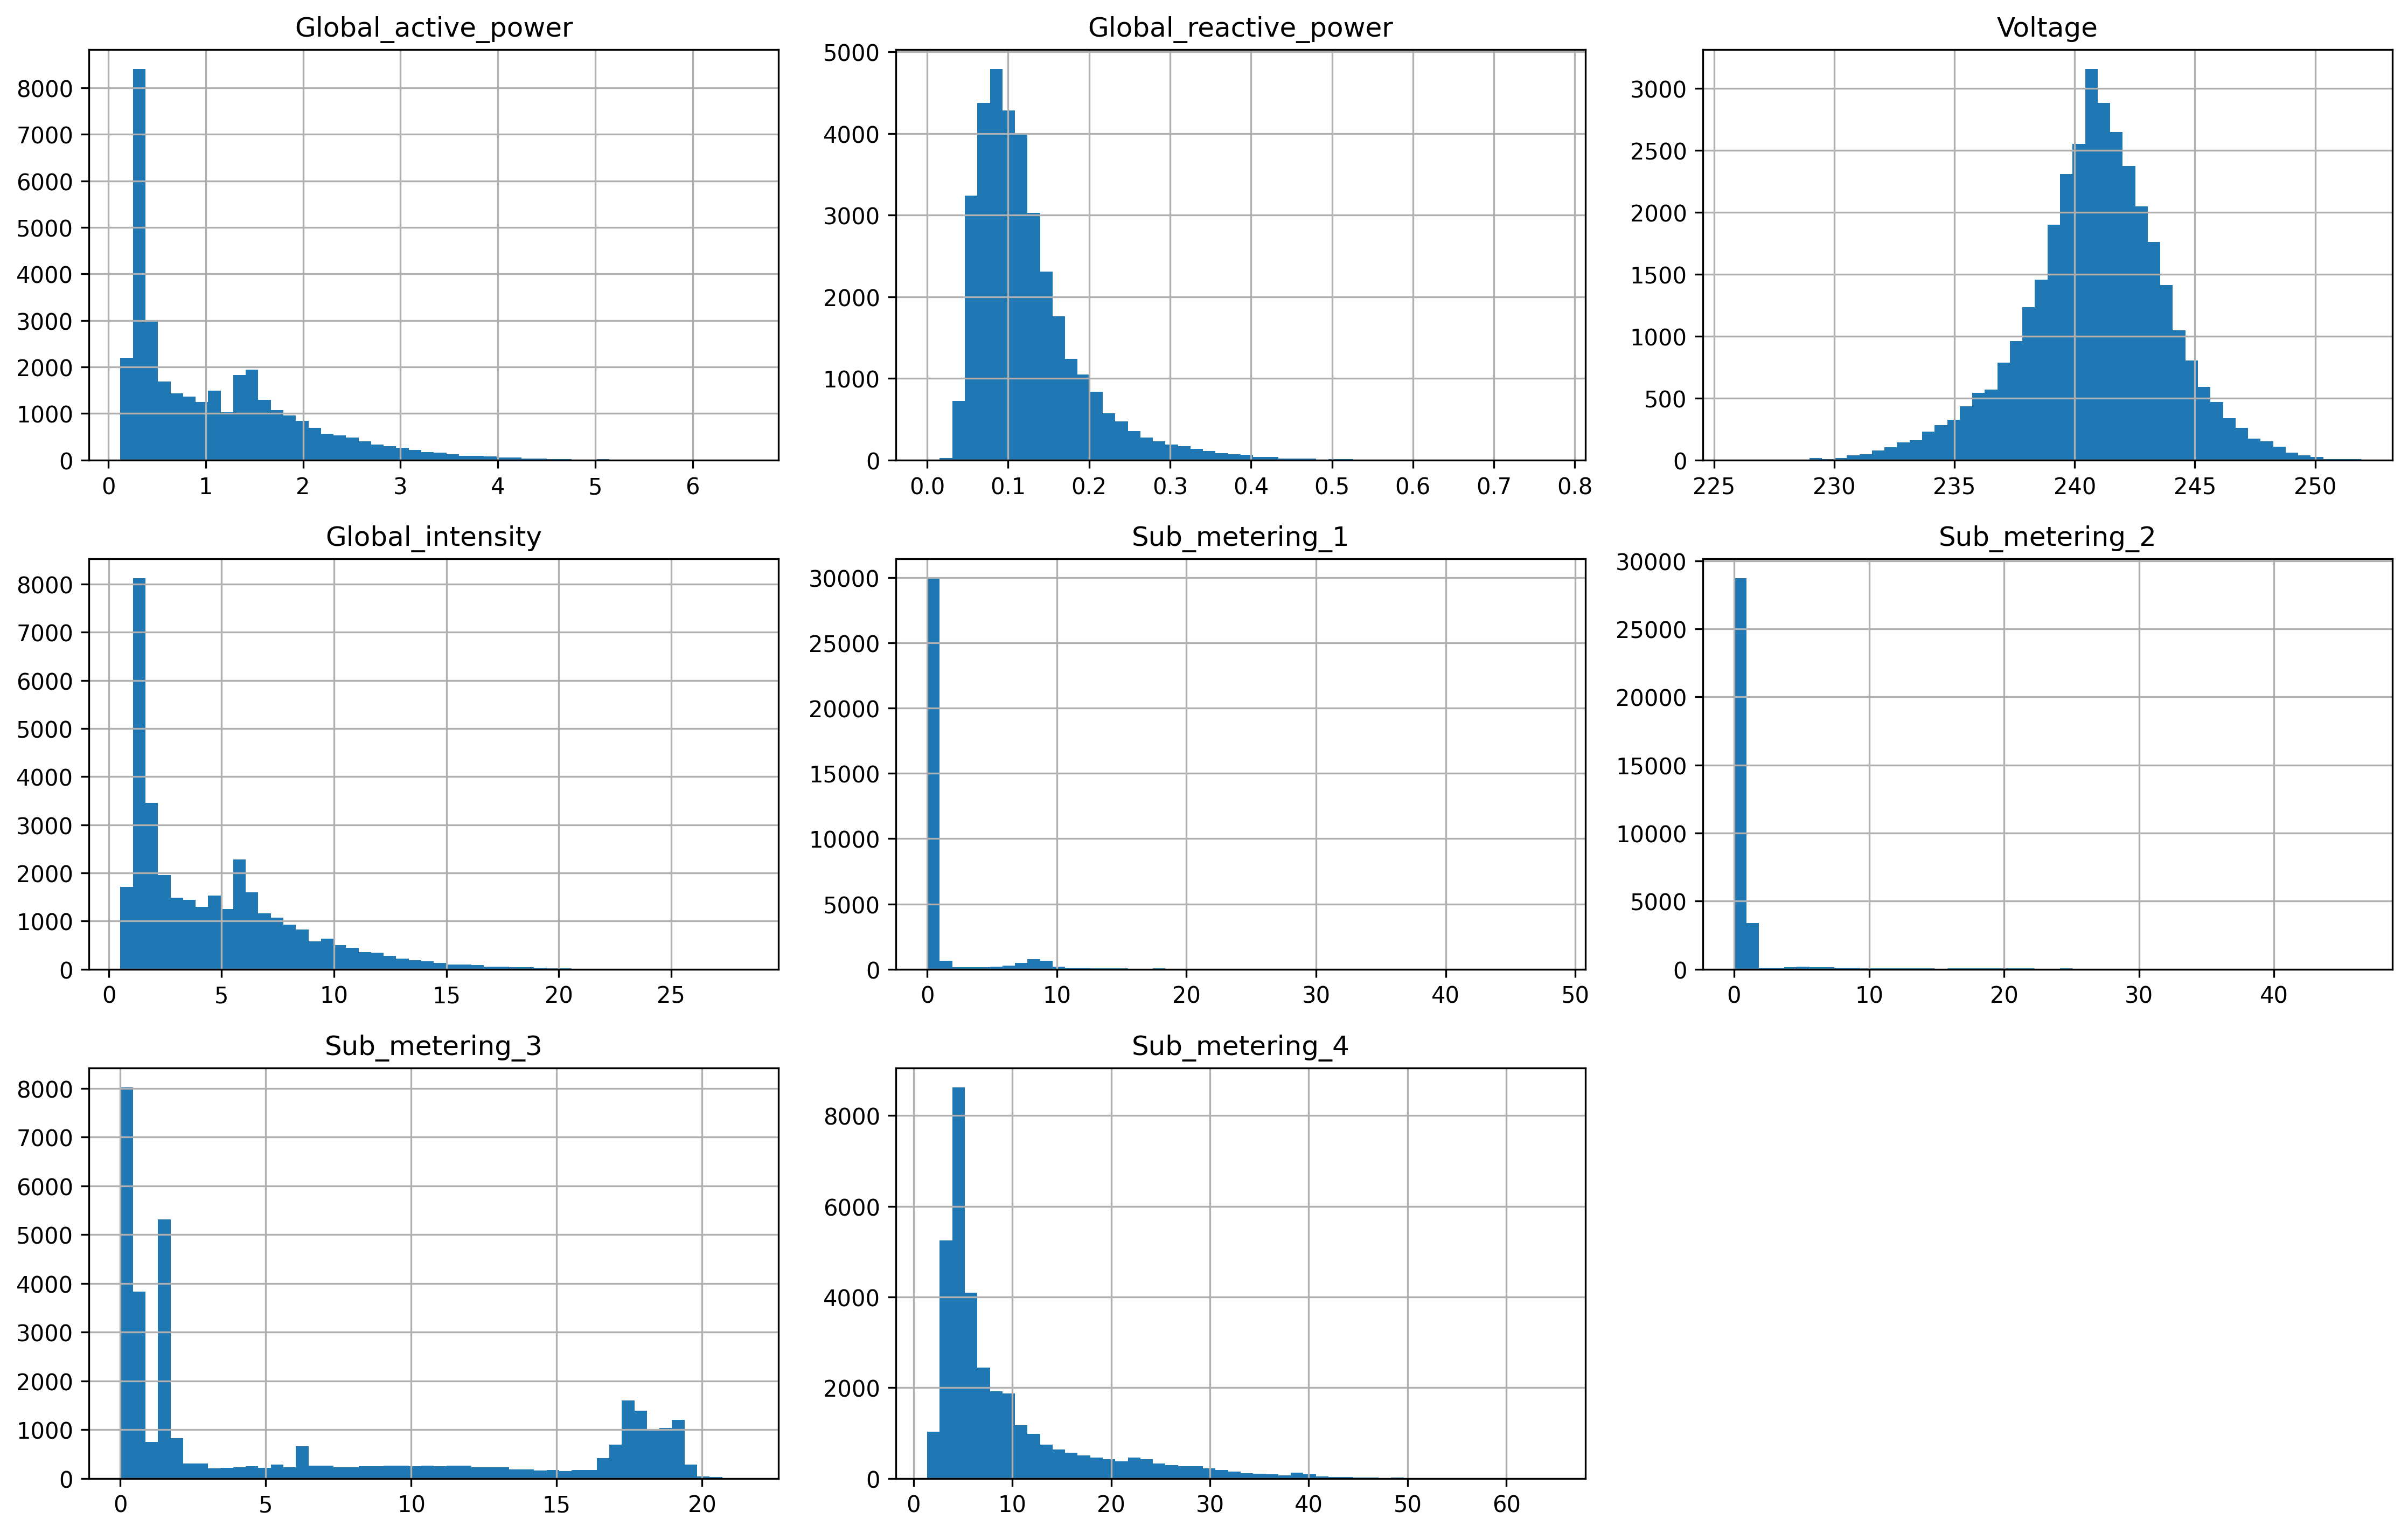

 

************************************************ Correlation Plot for Hourly Resampled Data **************************************************



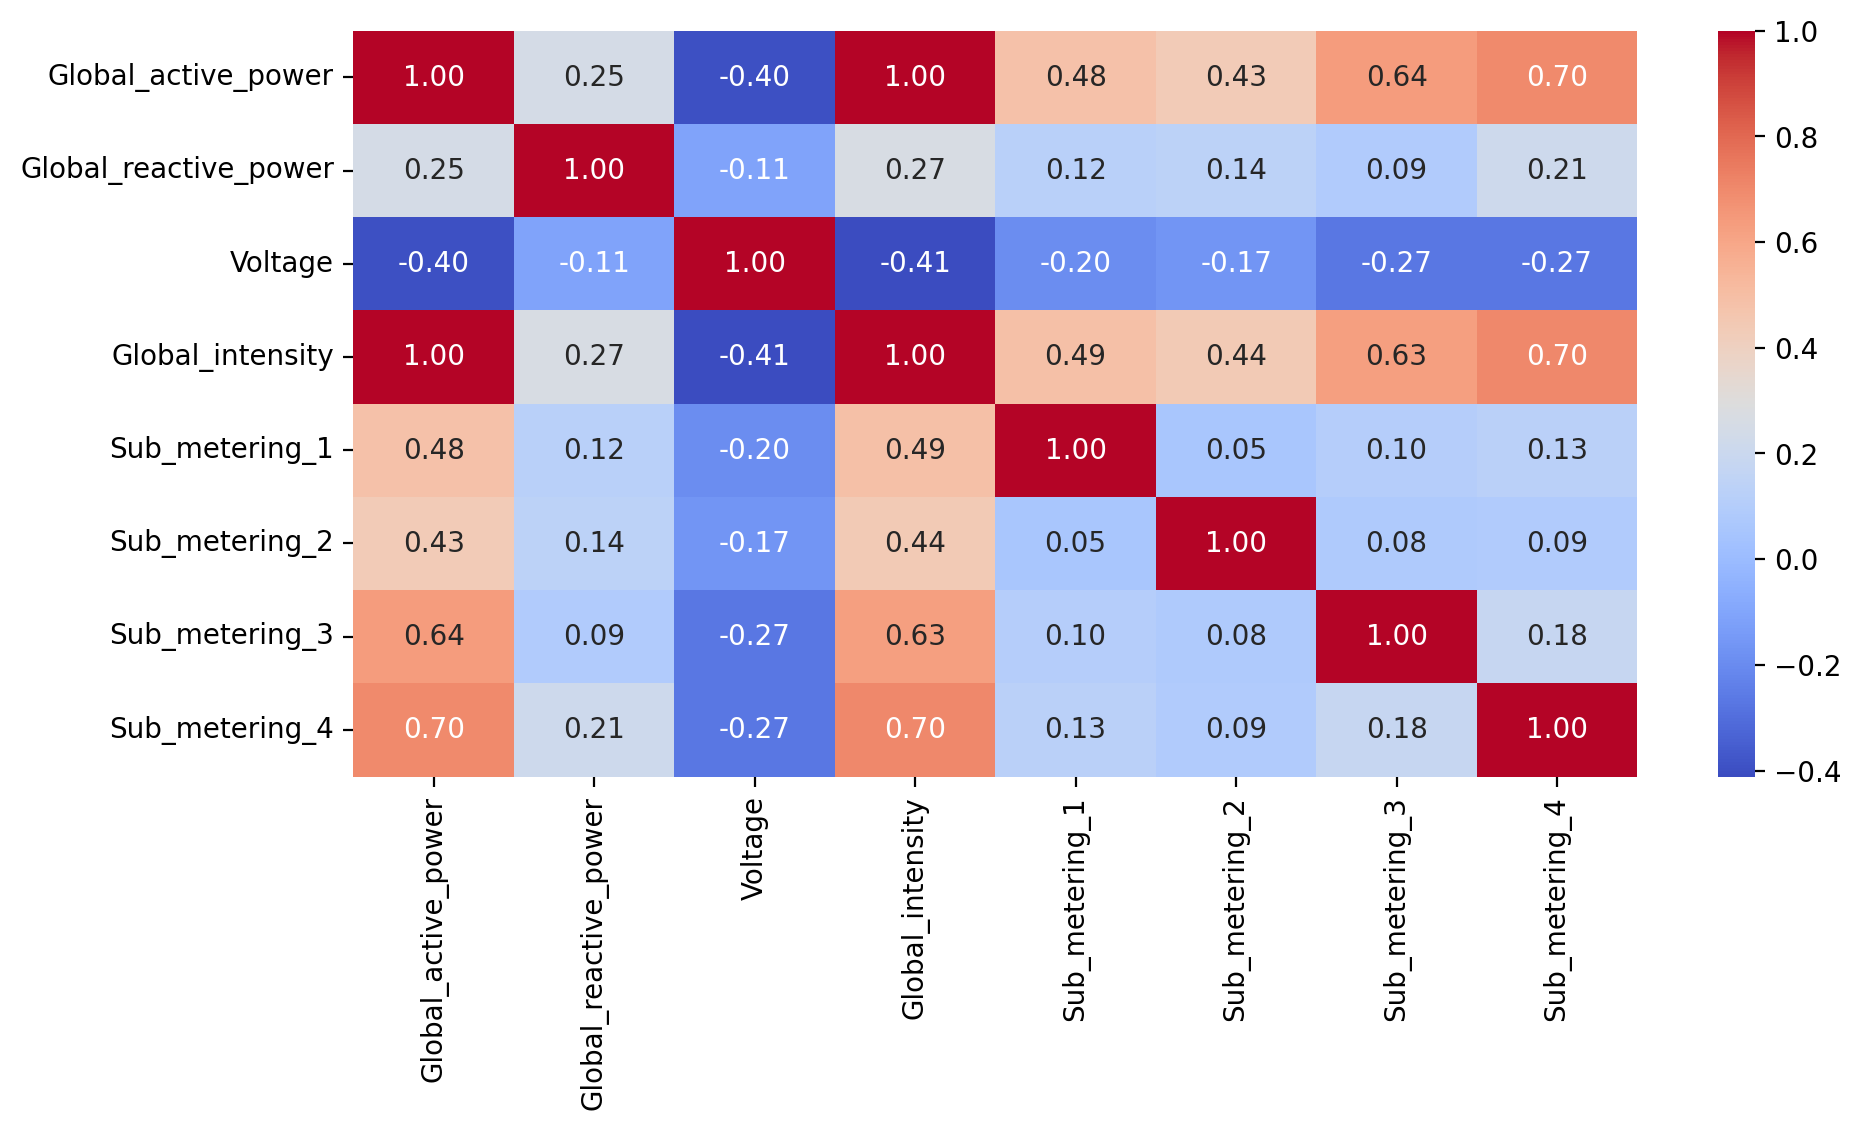

In [15]:
# Plot the visualization, distribution and correlation of Hourly resampled data
df_visu_dist_corr(df_imputed, "H", "Hourly")

Note:- As Global_intensity is highly correlated with Global_active_power so I am removing Global_intensity column

In [16]:
df1 = hourly_resampled.drop(['Global_intensity','Sub_metering_4'], axis=1)
df1

Global_active_power  Global_reactive_power     Voltage  \
date_time                                                                     
2006-12-16 17:00:00             4.222889               0.229000  234.643889   
2006-12-16 18:00:00             3.632200               0.080033  234.580167   
2006-12-16 19:00:00             3.400233               0.085233  233.232500   
2006-12-16 20:00:00             3.268567               0.075100  234.071500   
2006-12-16 21:00:00             3.056467               0.076667  237.158667   
...                                  ...                    ...         ...   
2010-11-26 17:00:00             1.725900               0.061400  237.069667   
2010-11-26 18:00:00             1.573467               0.053700  237.531833   
2010-11-26 19:00:00             1.659333               0.060033  236.741000   
2010-11-26 20:00:00             1.163700               0.061167  239.396000   
2010-11-26 21:00:00             0.934667               0.000000  239.690000   

                     Sub_metering_1  Sub_metering_2  Sub_metering_3  
date_time                                                            
2006-12-16 17:00:00             0.0        0.527778       16.861111  
2006-12-16 18:00:00             0.0        6.716667       16.866667  
2006-12-16 19:00:00             0.0        1.433333       16.683333  
2006-12-16 20:00:00             0.0        0.000000       16.783333  
2006-12-16 21:00:00             0.0        0.416667       17.216667  
...                             ...             ...             ...  
2010-11-26 17:00:00             0.0        0.000000       12.866667  
2010-11-26 18:00:00             0.0        0.000000        0.000000  
2010-11-26 19:00:00             0.0        0.066667        0.000000  
2010-11-26 20:00:00             0.0        1.066667        0.000000  
2010-11-26 21:00:00             0.0        0.000000        0.000000  

[34589 rows x 6 columns]

## Data Normalization

In [17]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(df1)

# Shape of scaled data
scaled_df

array([[0.63681623, 0.29573827, 0.33794529, 0.        , 0.01136636,
        0.78241815],
       [0.54504495, 0.10335773, 0.33550078, 0.        , 0.14465183,
        0.78267595],
       [0.50900588, 0.11007318, 0.28380167, 0.        , 0.03086863,
        0.7741686 ],
       ...,
       [0.2385342 , 0.07752906, 0.41839455, 0.        , 0.00143575,
        0.        ],
       [0.16153105, 0.07899268, 0.52024552, 0.        , 0.022972  ,
        0.        ],
       [0.12594772, 0.        , 0.53152393, 0.        , 0.        ,
        0.        ]])

## LSTM-1 seq=12 epochs=50 batch_size=32

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
865/865 - 9s - 11ms/step - loss: 0.0126 - val_loss: 0.0087
Epoch 2/50
865/865 - 5s - 6ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 3/50
865/865 - 4s - 4ms/step - loss: 0.0088 - val_loss: 0.0087
Epoch 4/50
865/865 - 5s - 6ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 5/50
865/865 - 4s - 4ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 6/50
865/865 - 5s - 6ms/step - loss: 0.0083 - val_loss: 0.0084
Epoch 7/50
865/865 - 5s - 6ms/step - loss: 0.0082 - val_loss: 0.0084
Epoch 8/50
865/865 - 4s - 5ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 9/50
865/865 - 7s - 8ms/step - loss: 0.0081 - val_loss: 0.0083
Epoch 10/50
865/865 - 6s - 7ms/step - loss: 0.0080 - val_loss: 0.0080
Epoch 11/50
865/865 - 8s - 9ms/step - loss: 0.0080 - val_loss: 0.0084
Epoch 12/50
865/865 - 6s - 7ms/step - loss: 0.0080 - val_loss: 0.0081
Epoch 13/50
865/865 - 4s - 5ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 14/50
865/865 - 6s - 7ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 15/50
865/865 - 6s - 7

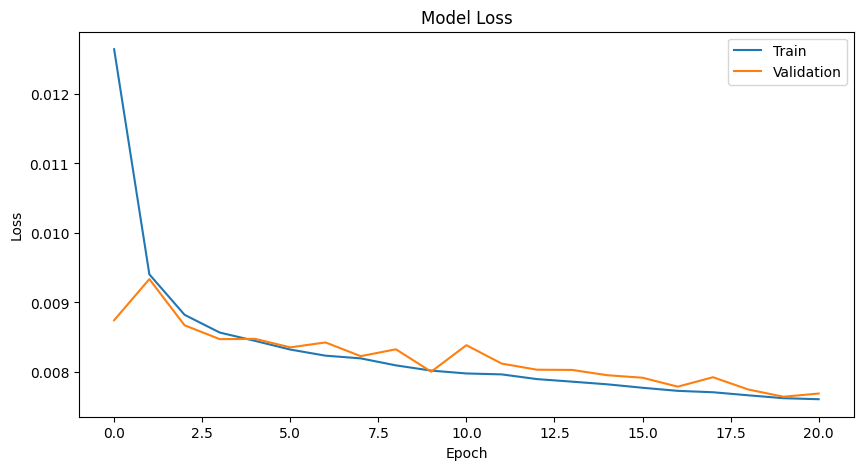

865/865 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train MAE: 0.47630388116097677
Train MSE: 0.3733979213654246
Train RMSE: 0.6110629438653801

Test MAE: 0.45418182284386327
Test MSE: 0.3185060819500602
Test RMSE: 0.5643634307341858


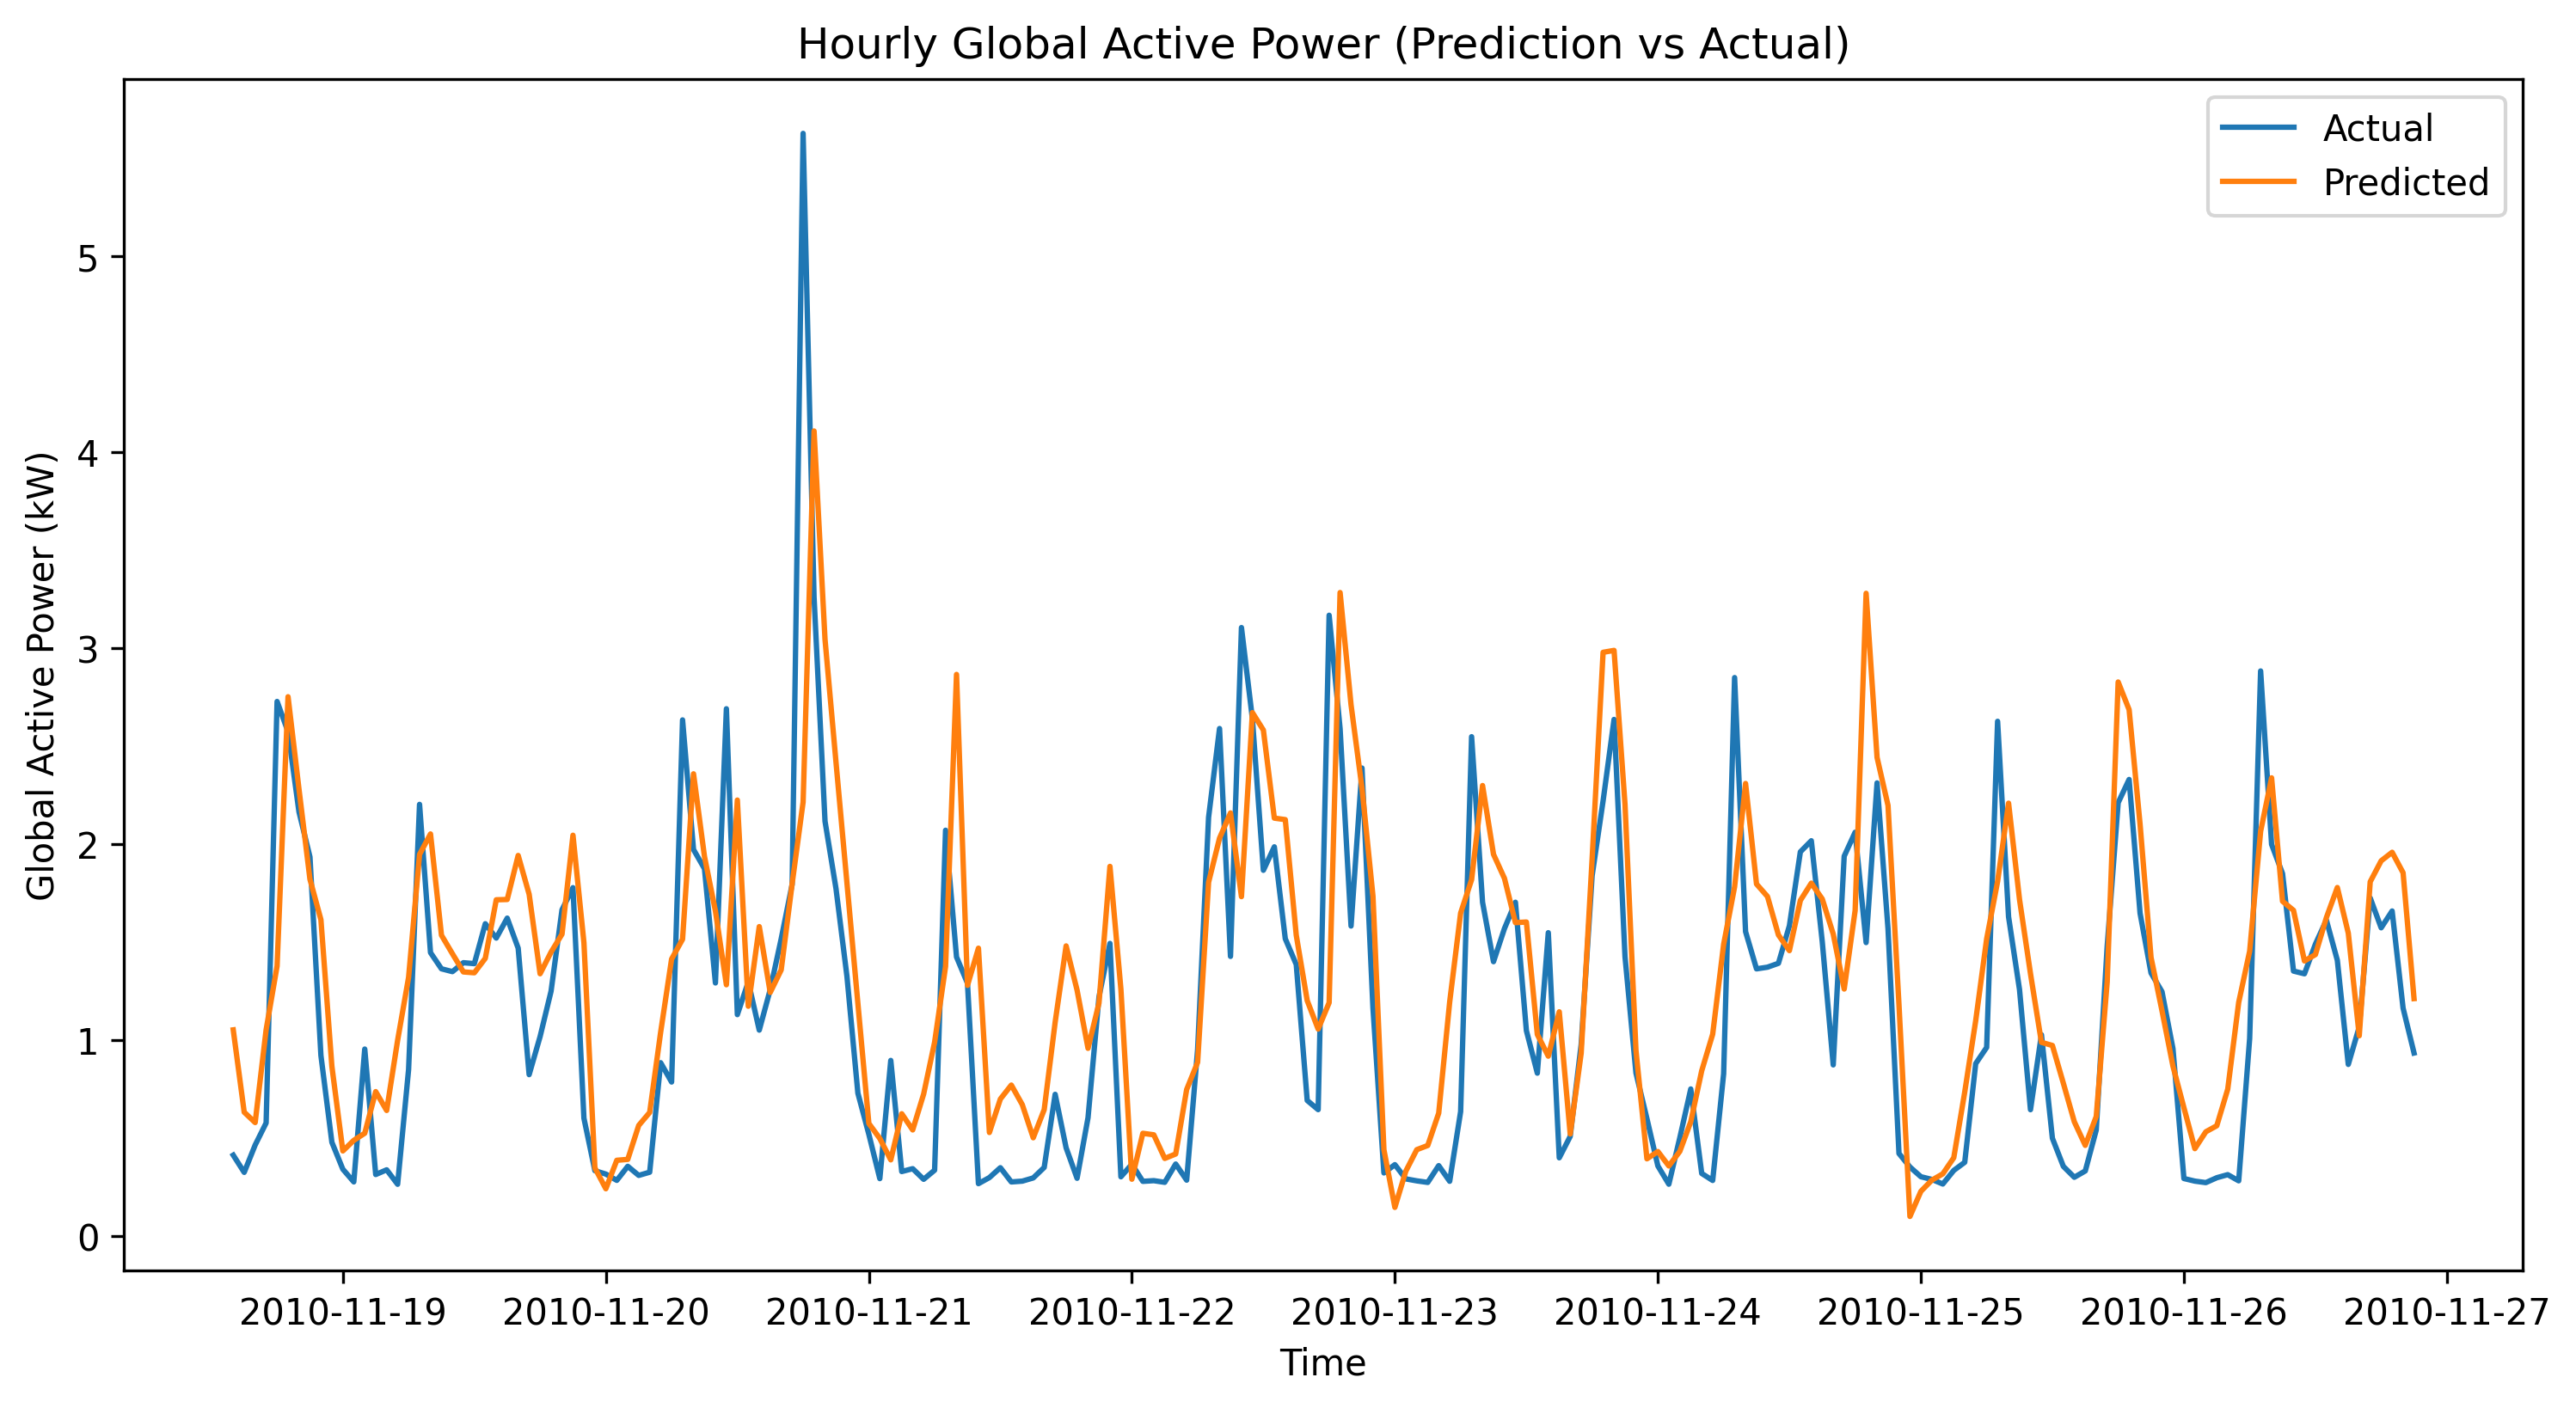

In [19]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Displaying a summary of the model
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20 , min_delta=0.005)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False, callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print('Train MAE:', mean_absolute_error(true_train_y, pred_train_y))
print('Train MSE:', mean_squared_error(true_train_y, pred_train_y))
print('Train RMSE:',np.sqrt(mean_squared_error(true_train_y, pred_train_y)))

print('\nTest MAE:', mean_absolute_error(true_test_y, pred_test_y))
print('Test MSE:', mean_squared_error(true_test_y, pred_test_y))
print('Test RMSE:',np.sqrt(mean_squared_error(true_test_y, pred_test_y)))

# Plotting predicted and actual temperatures
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_test_y[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_test_y[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

## LSTM-2 seq=24 epochs=50 batch_size=32

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
865/865 - 8s - 9ms/step - loss: 0.0124 - val_loss: 0.0097
Epoch 2/50
865/865 - 7s - 8ms/step - loss: 0.0093 - val_loss: 0.0089
Epoch 3/50
865/865 - 6s - 6ms/step - loss: 0.0086 - val_loss: 0.0083
Epoch 4/50
865/865 - 4s - 5ms/step - loss: 0.0083 - val_loss: 0.0077
Epoch 5/50
865/865 - 5s - 6ms/step - loss: 0.0082 - val_loss: 0.0073
Epoch 6/50
865/865 - 4s - 4ms/step - loss: 0.0080 - val_loss: 0.0069
Epoch 7/50
865/865 - 4s - 4ms/step - loss: 0.0079 - val_loss: 0.0069
Epoch 8/50
865/865 - 6s - 7ms/step - loss: 0.0078 - val_loss: 0.0068
Epoch 9/50
865/865 - 5s - 5ms/step - loss: 0.0078 - val_loss: 0.0073
Epoch 10/50
865/865 - 5s - 5ms/step - loss: 0.0077 - val_loss: 0.0068
Epoch 11/50
865/865 - 6s - 7ms/step - loss: 0.0076 - val_loss: 0.0070
Epoch 12/50
865/865 - 9s - 10ms/step - loss: 0.0076 - val_loss: 0.0068
Epoch 13/50
865/865 - 6s - 7ms/step - loss: 0.0075 - val_loss: 0.0068
Epoch 14/50
865/865 - 4s - 5ms/step - loss: 0.0075 - val_loss: 0.0067
Epoch 15/50
865/865 - 4s - 4

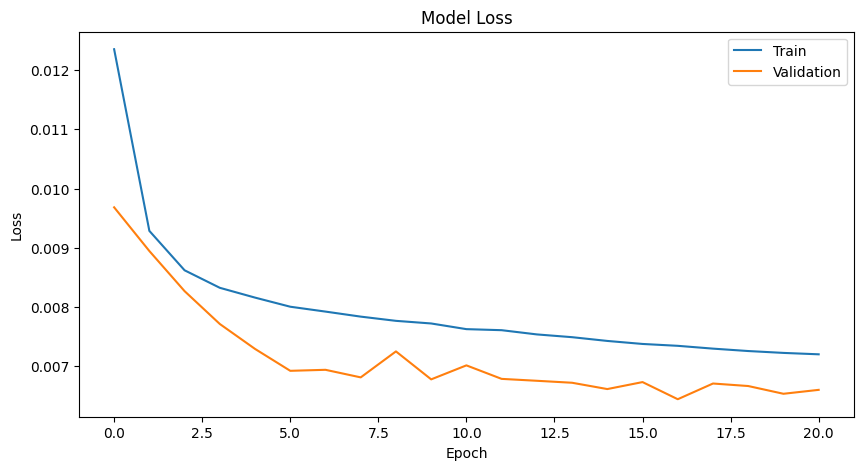

865/865 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train MAE: 0.43604365285297203
Train MSE: 0.3401342312217921
Train RMSE: 0.5832102804493351

Test MAE: 0.39412348620323273
Test MSE: 0.2734733821408886
Test RMSE: 0.5229468253473661


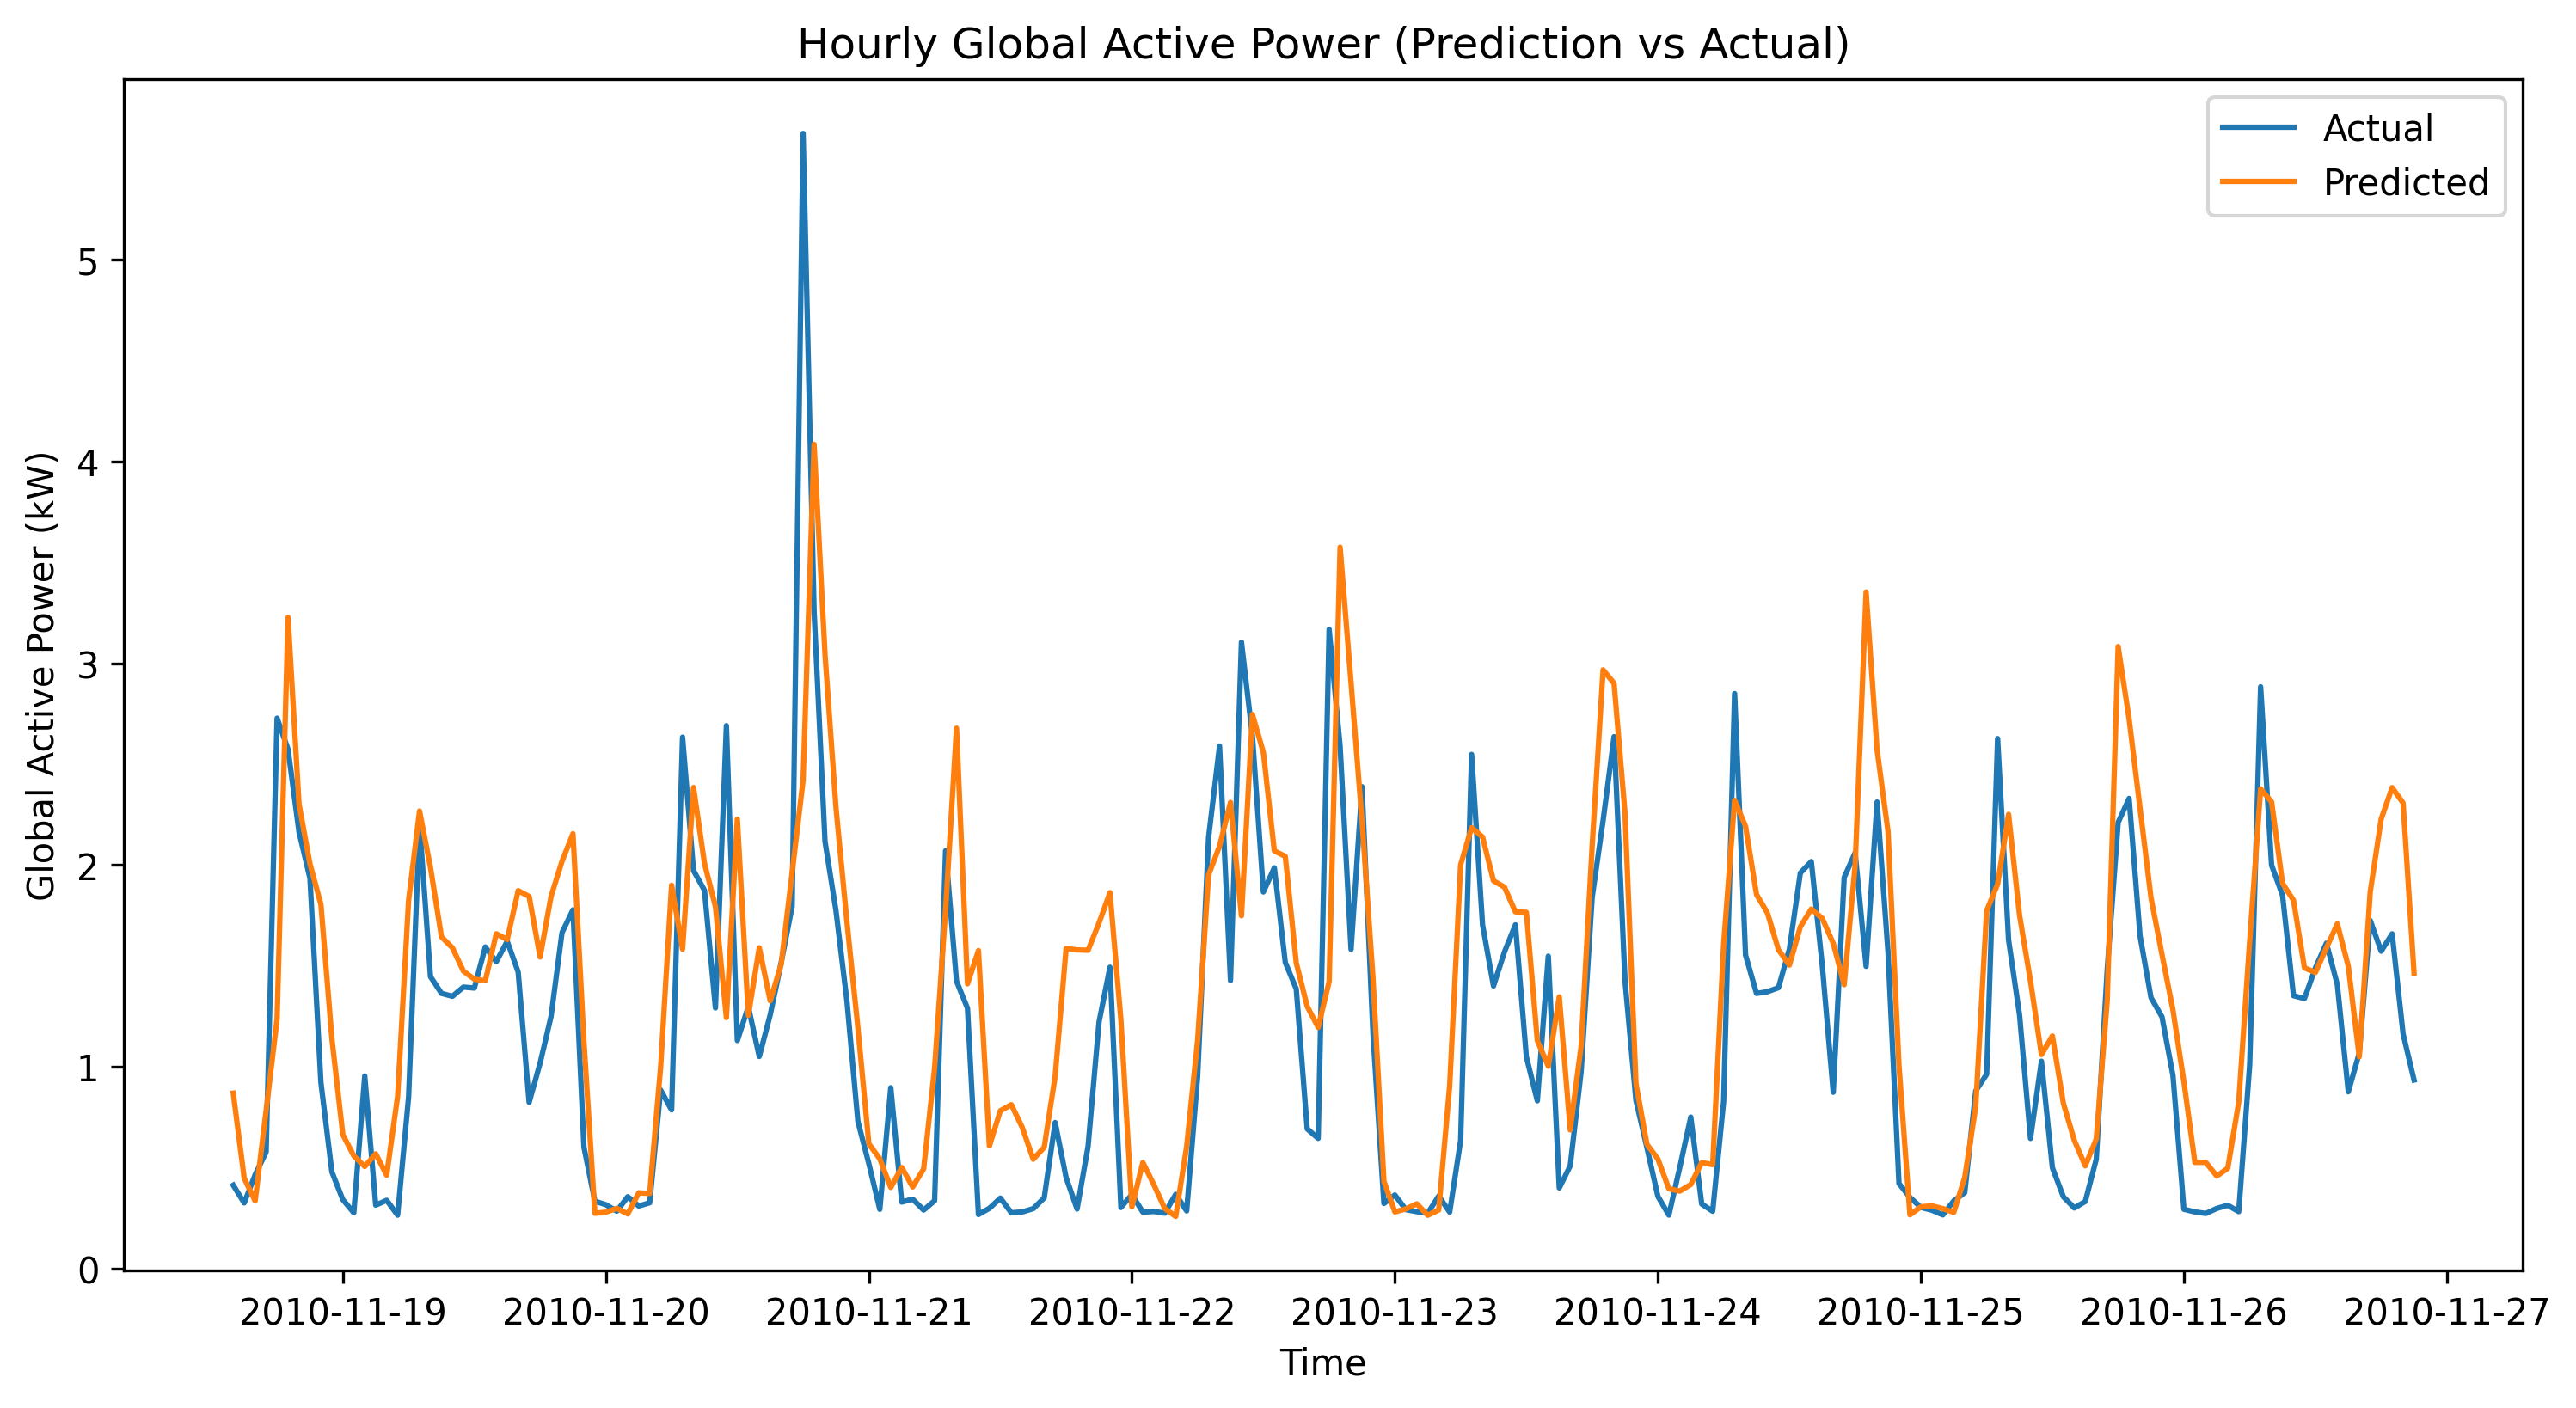

In [20]:
# Define sequence length and features
sequence_length = 24             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Displaying a summary of the model
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20 , min_delta=0.005)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False, callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print('Train MAE:', mean_absolute_error(true_train_y, pred_train_y))
print('Train MSE:', mean_squared_error(true_train_y, pred_train_y))
print('Train RMSE:',np.sqrt(mean_squared_error(true_train_y, pred_train_y)))

print('\nTest MAE:', mean_absolute_error(true_test_y, pred_test_y))
print('Test MSE:', mean_squared_error(true_test_y, pred_test_y))
print('Test RMSE:',np.sqrt(mean_squared_error(true_test_y, pred_test_y)))

# Plotting predicted and actual temperatures
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_test_y[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_test_y[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

## LSTM-3 seq=48 epochs=50 batch_size=32

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
864/864 - 6s - 7ms/step - loss: 0.0121 - val_loss: 0.0092
Epoch 2/50
864/864 - 5s - 5ms/step - loss: 0.0093 - val_loss: 0.0091
Epoch 3/50
864/864 - 5s - 6ms/step - loss: 0.0087 - val_loss: 0.0089
Epoch 4/50
864/864 - 4s - 5ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 5/50
864/864 - 5s - 6ms/step - loss: 0.0082 - val_loss: 0.0086
Epoch 6/50
864/864 - 11s - 12ms/step - loss: 0.0081 - val_loss: 0.0084
Epoch 7/50
864/864 - 9s - 10ms/step - loss: 0.0080 - val_loss: 0.0082
Epoch 8/50
864/864 - 4s - 5ms/step - loss: 0.0078 - val_loss: 0.0079
Epoch 9/50
864/864 - 7s - 8ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 10/50
864/864 - 7s - 8ms/step - loss: 0.0077 - val_loss: 0.0073
Epoch 11/50
864/864 - 7s - 8ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 12/50
864/864 - 8s - 10ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 13/50
864/864 - 7s - 8ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 14/50
864/864 - 4s - 5ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 15/50
864/864 - 5s 

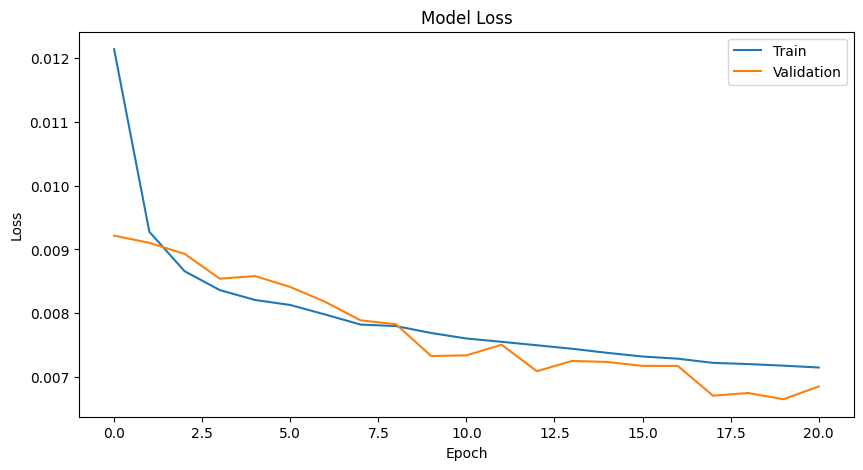

864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train MAE: 0.457752250128912
Train MSE: 0.3563590610389923
Train RMSE: 0.5969581736093345

Test MAE: 0.41028146765954154
Test MSE: 0.2838318122736413
Test RMSE: 0.5327586810870765


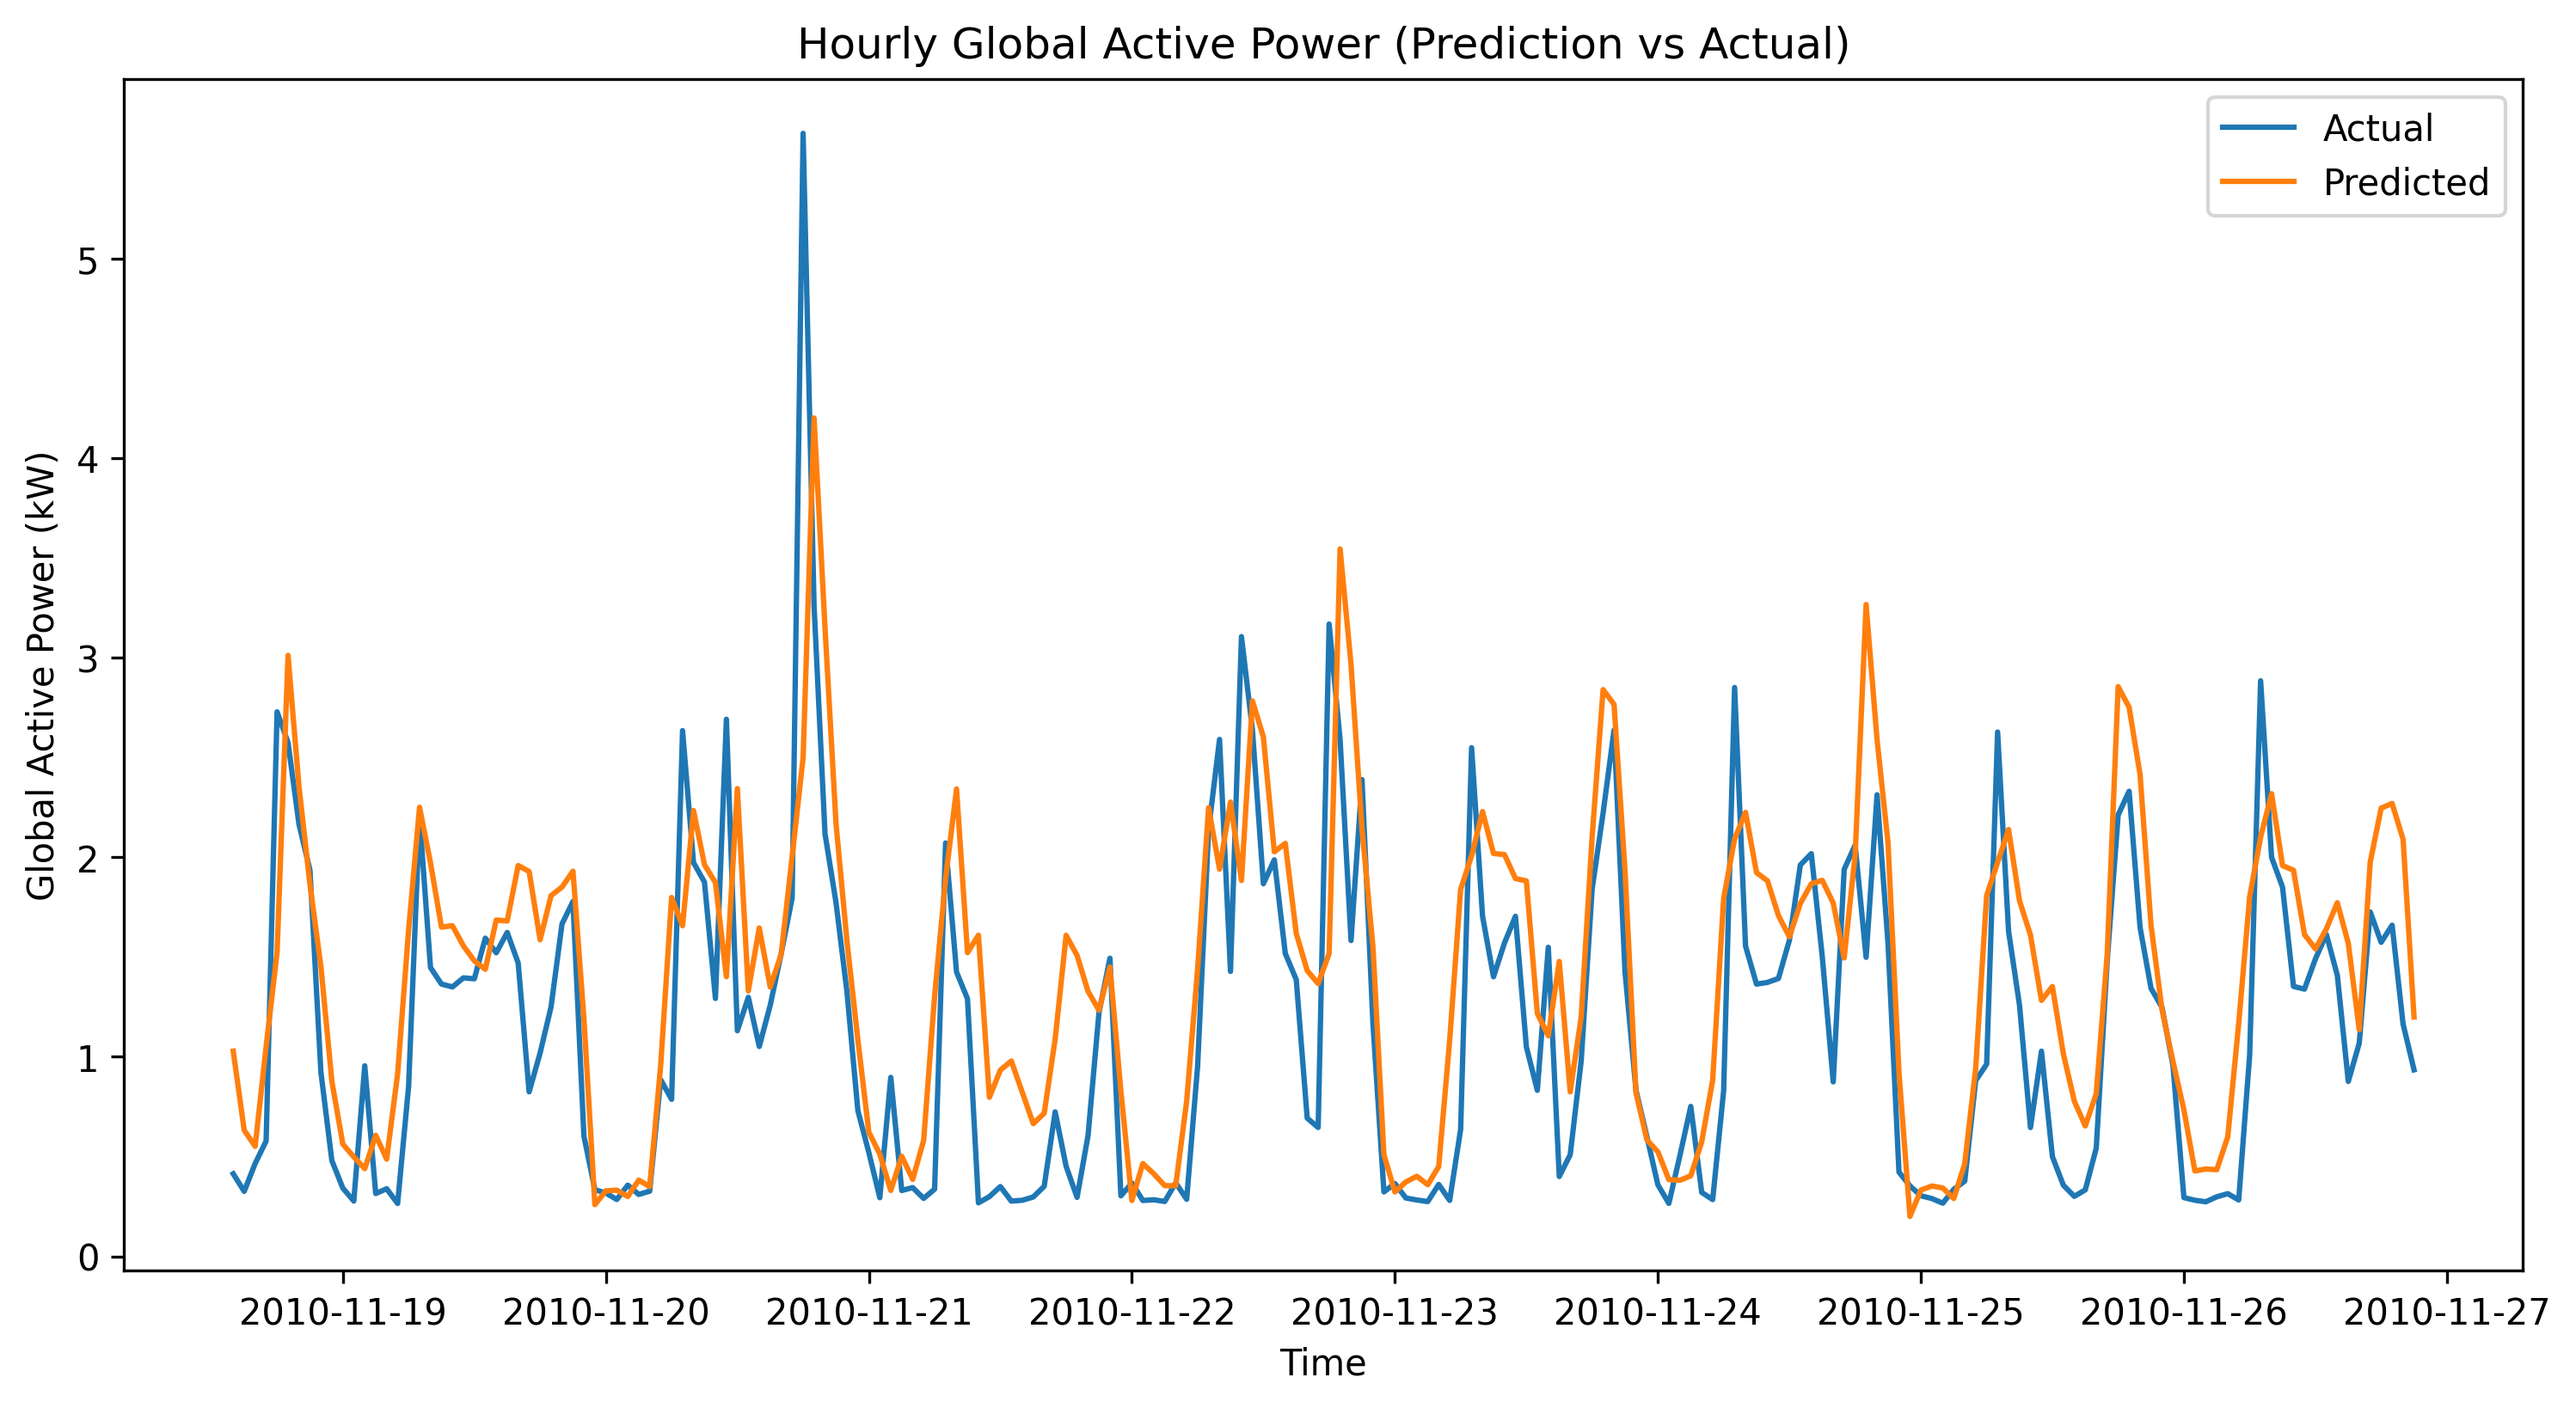

In [21]:
# Define sequence length and features
sequence_length = 48             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Displaying a summary of the model
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20 , min_delta=0.005)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False, callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print('Train MAE:', mean_absolute_error(true_train_y, pred_train_y))
print('Train MSE:', mean_squared_error(true_train_y, pred_train_y))
print('Train RMSE:',np.sqrt(mean_squared_error(true_train_y, pred_train_y)))

print('\nTest MAE:', mean_absolute_error(true_test_y, pred_test_y))
print('Test MSE:', mean_squared_error(true_test_y, pred_test_y))
print('Test RMSE:',np.sqrt(mean_squared_error(true_test_y, pred_test_y)))

# Plotting predicted and actual temperatures
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_test_y[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_test_y[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# Daily resampled data

In [22]:
# Resampled the data
daily_resampled = df_imputed.resample('D').mean()

## EDA

In [23]:
# Define a function to plot the visualization, distribution and correlation of resampled data
def df_visu_dist_corr(dataset, resample_type, title):

  # Resample the data
  df_resampled = dataset.resample(resample_type).mean()

  print('Shape after %s resampling of data : %s ' %(title, df_resampled.shape))

  # Plot Resampled Data set
  df_resampled.plot(subplots=True, figsize=(30,20))
  plt.suptitle("Visualization of %s resampled Data" %title, fontsize=30, color='blue')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

  # Plot distribution
  print(' \n\n************************************************ %s Resampled distribution Plot **************************************************' %title, end="\n\n")
  df_resampled.hist(figsize=(15, 10), bins=50)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(300)
  plt.show()

  # Plot correlation plot
  print(' \n\n************************************************ Correlation Plot for %s Resampled Data **************************************************' %title, end="\n\n")
  plt.figure(figsize=(10,6))
  sns.heatmap(df_imputed.corr(), annot=True, cmap='coolwarm', fmt='.2f')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(200)
  plt.show()

Shape after Daily resampling of data : (1442, 8) 


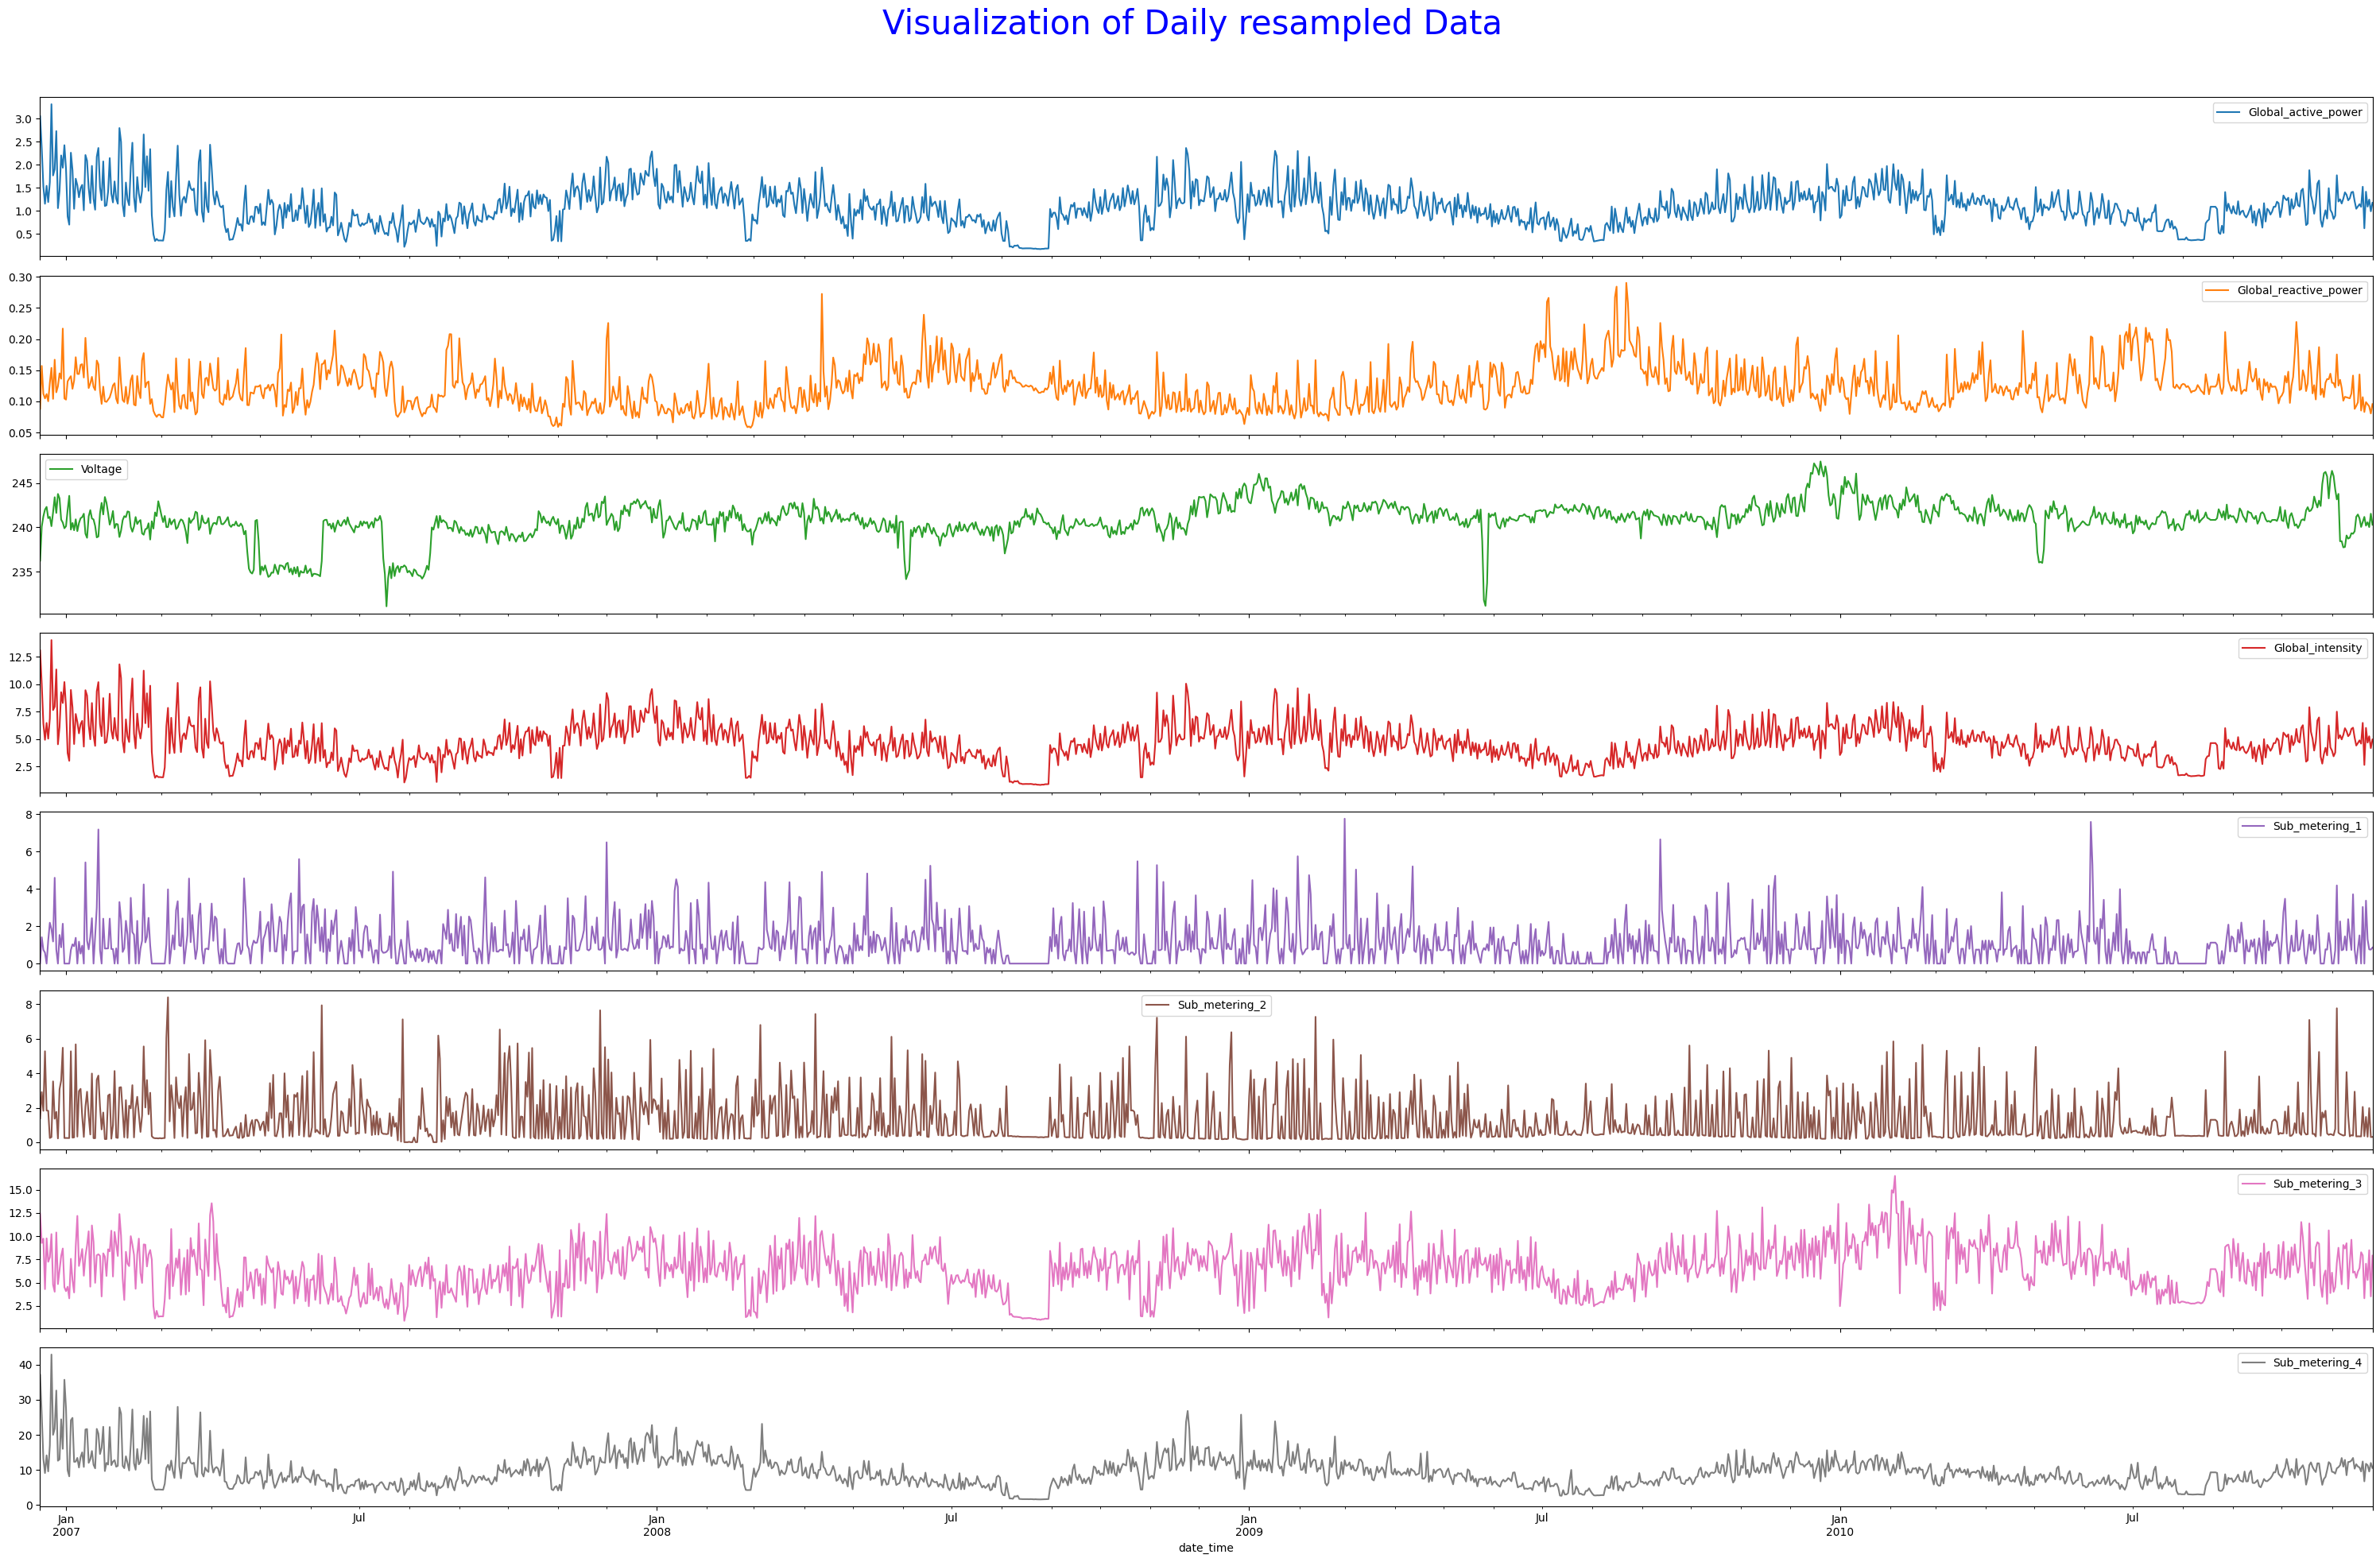

 

************************************************ Daily Resampled distribution Plot **************************************************



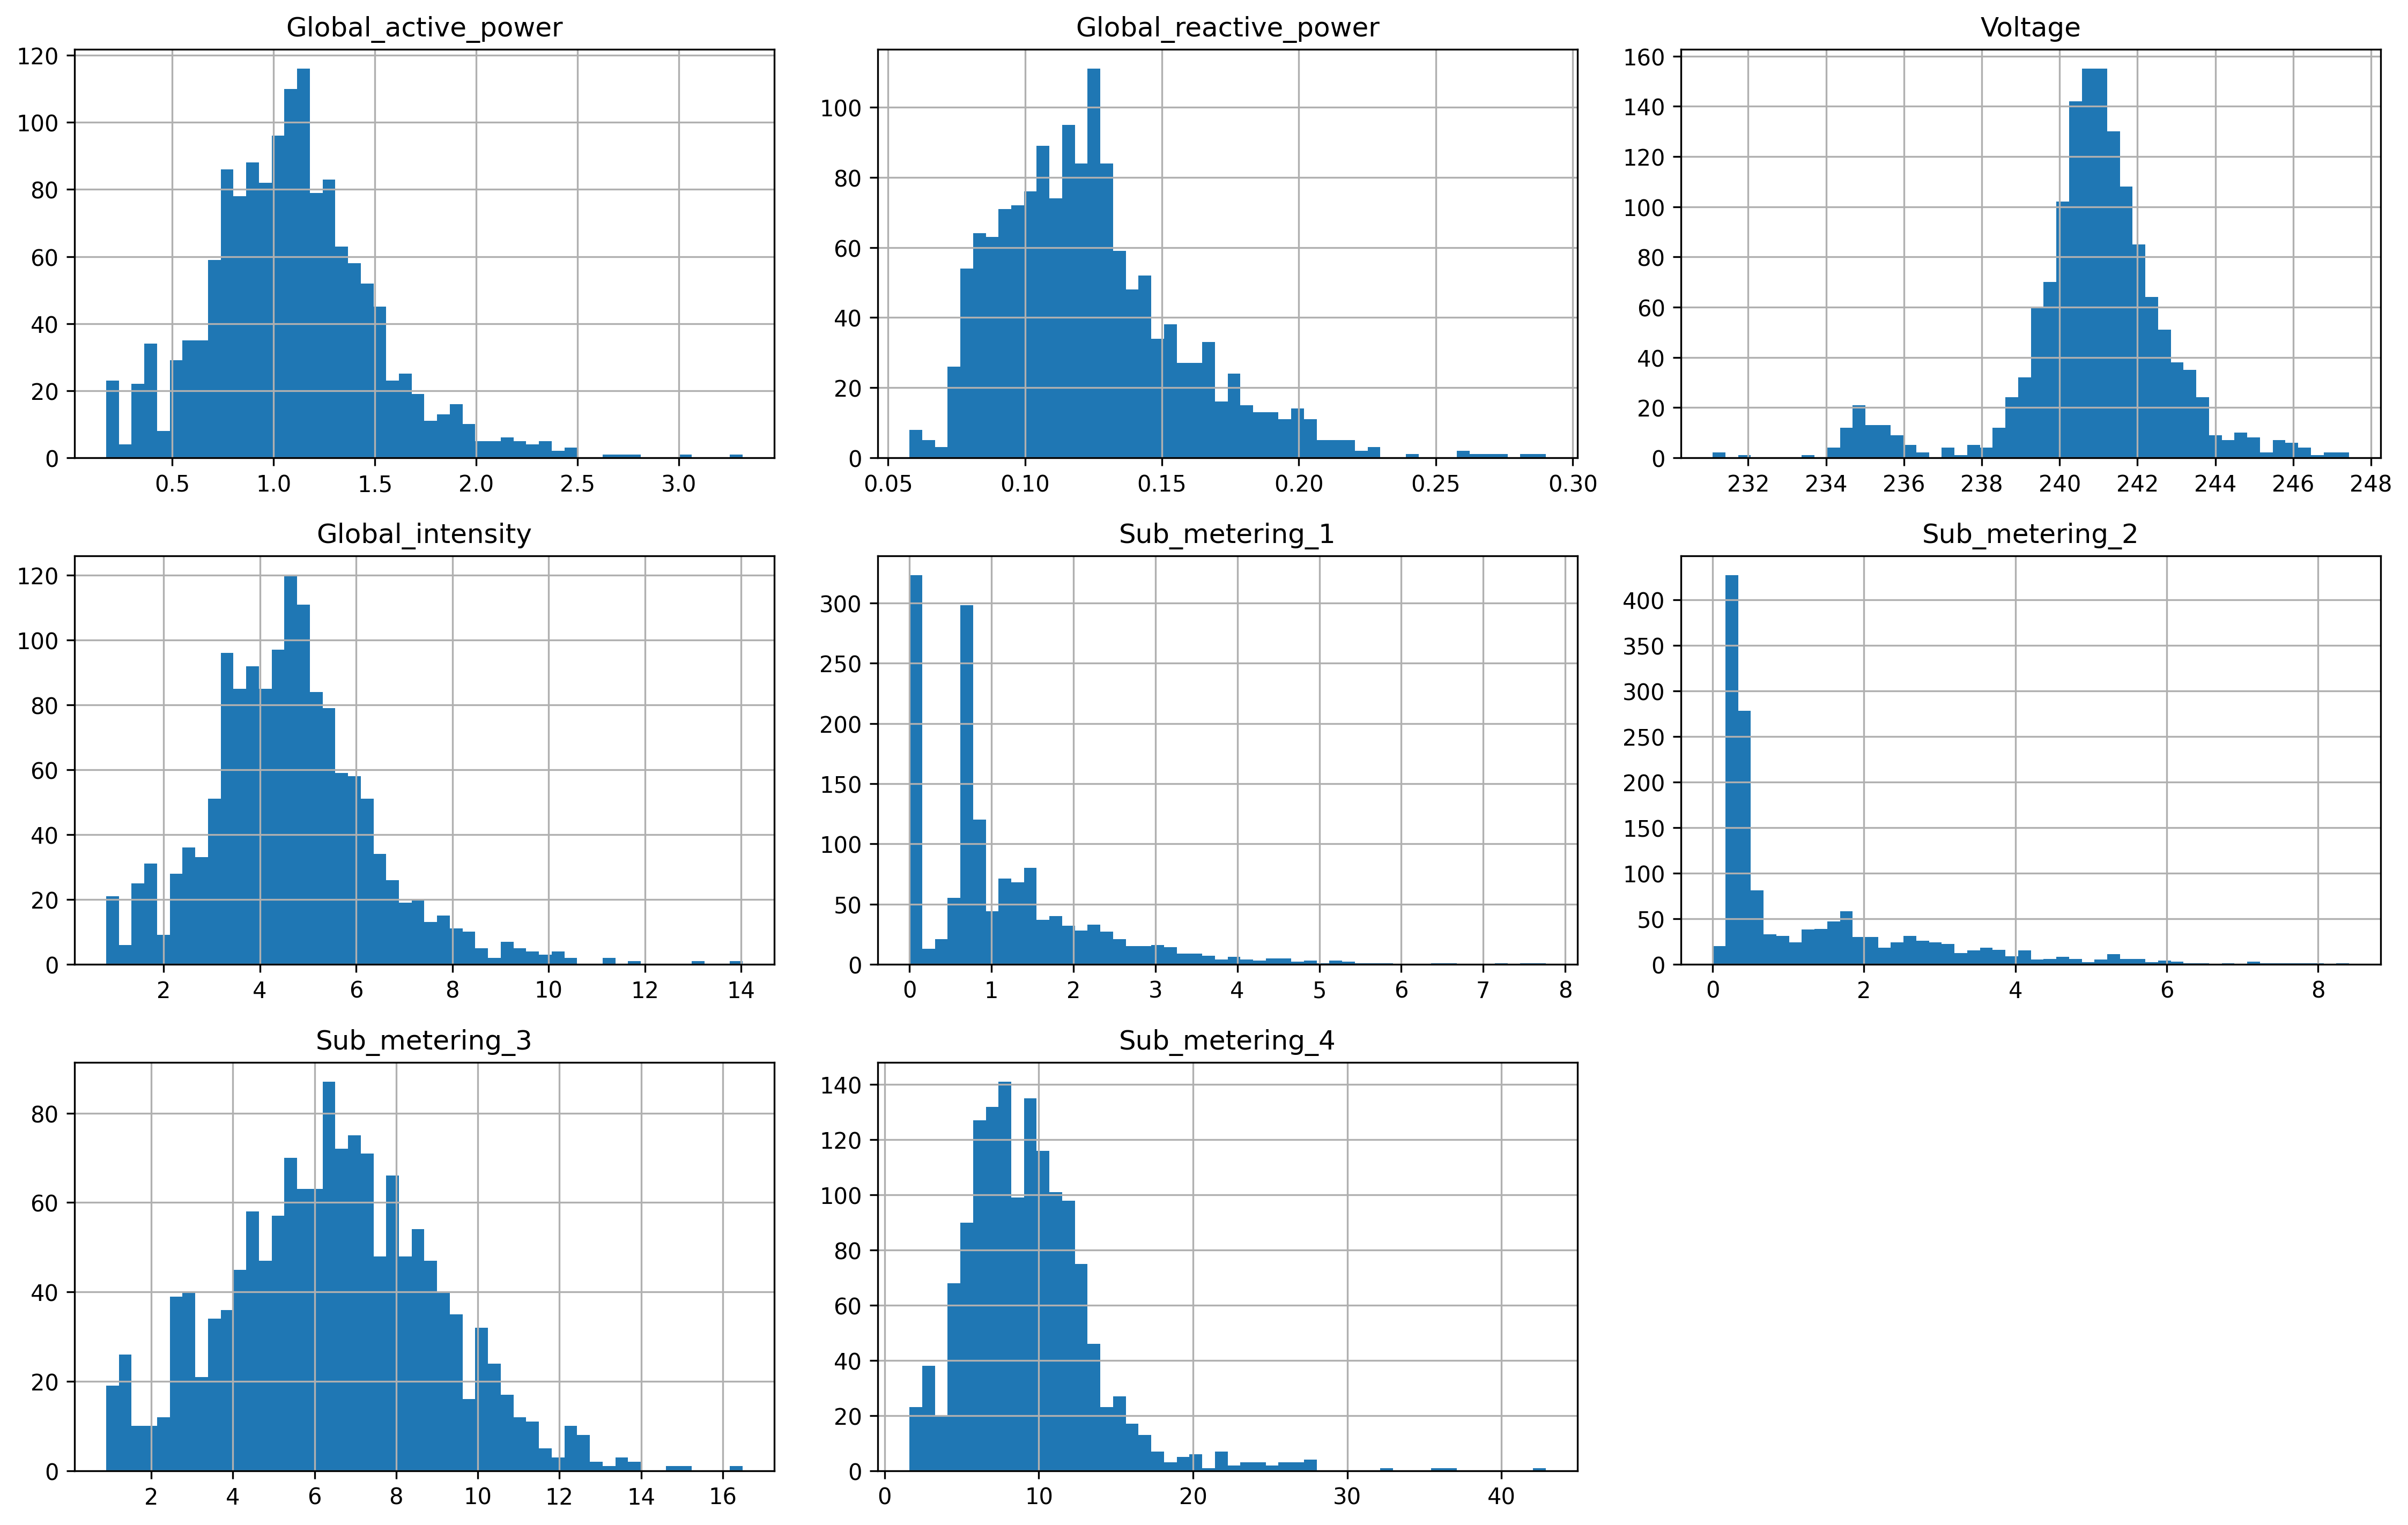

 

************************************************ Correlation Plot for Daily Resampled Data **************************************************



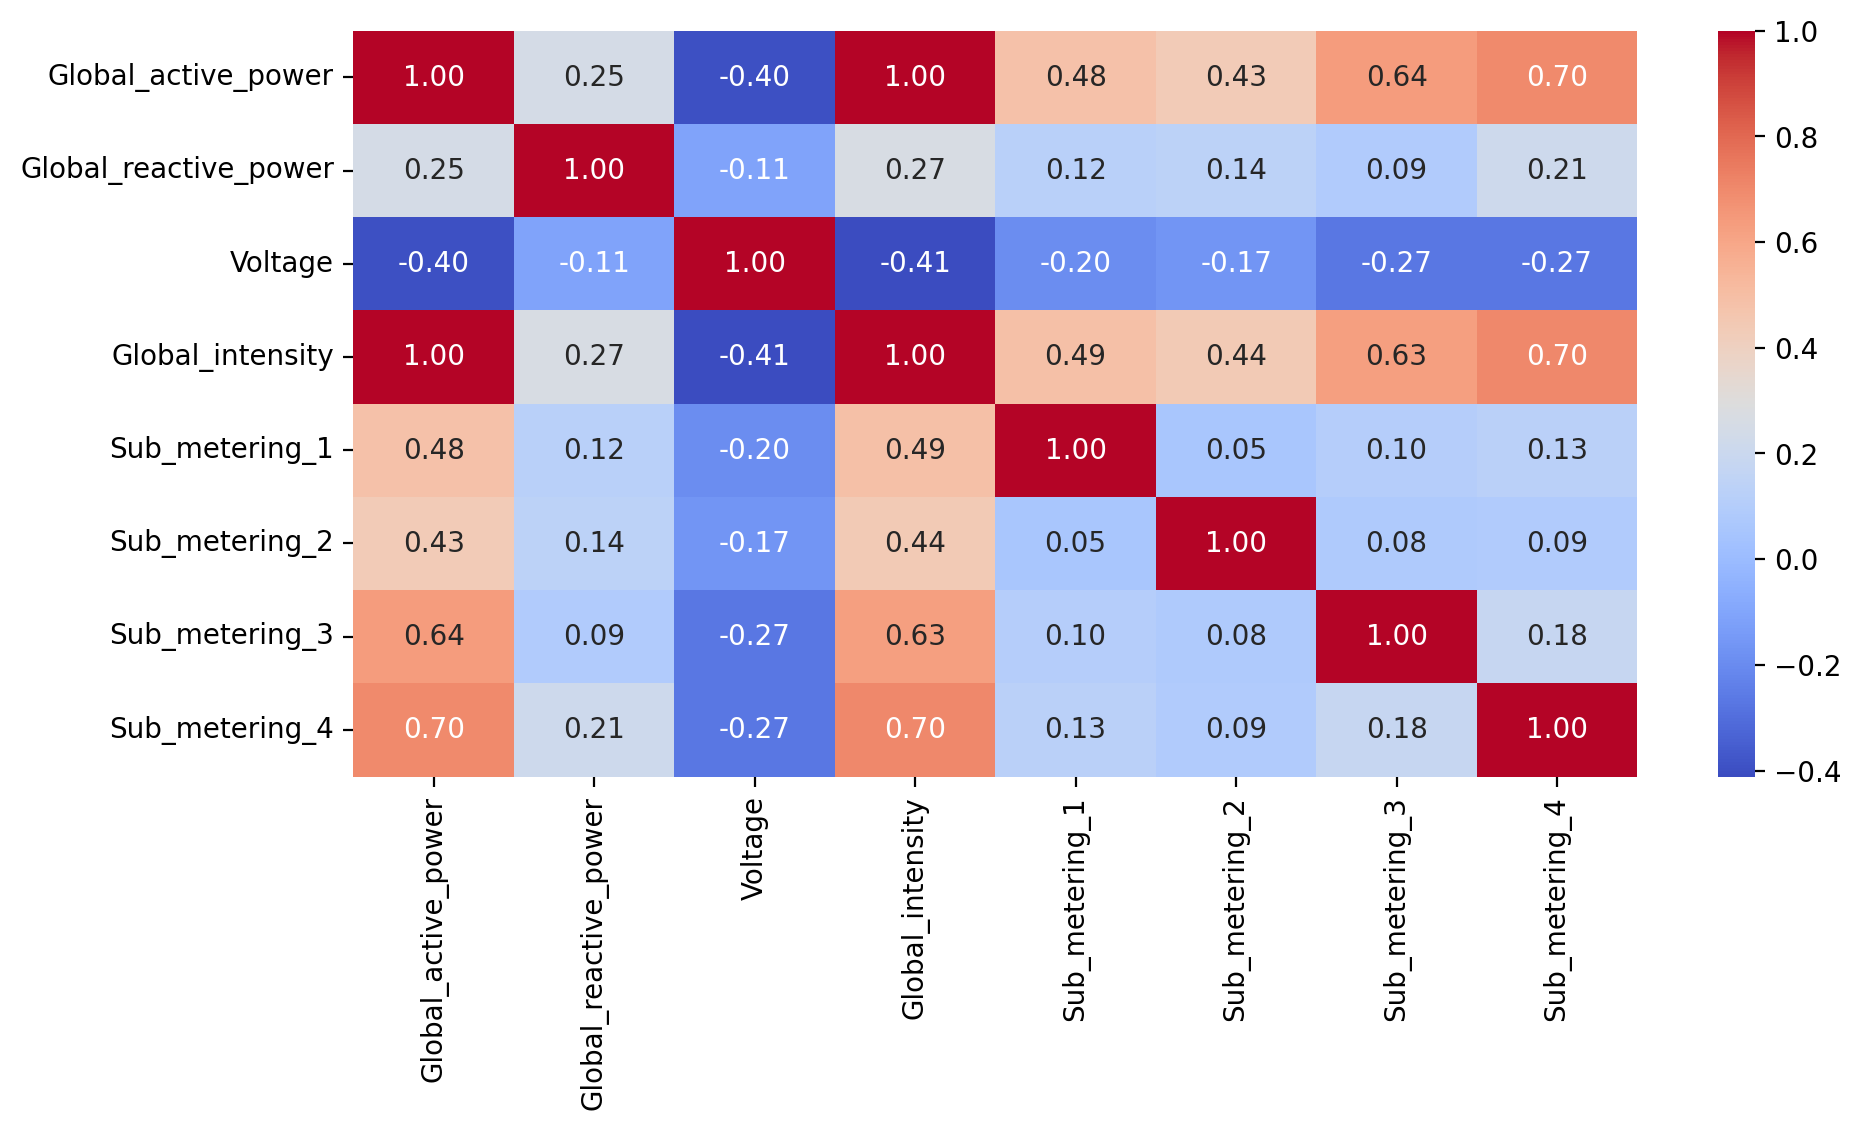

In [24]:
# Plot the visualization, distribution and correlation of Daily resampled data
df_visu_dist_corr(df_imputed, "D", "Daily")

Note:- As Global_intensity is highly correlated with Global_active_power so I am removing Global_intensity column

In [25]:
df2 = daily_resampled.drop(['Global_intensity','Sub_metering_4'], axis=1)
df2

Global_active_power  Global_reactive_power     Voltage  \
date_time                                                            
2006-12-16             3.053475               0.088187  236.243763   
2006-12-17             2.354486               0.156949  240.087028   
2006-12-18             1.530435               0.112356  241.231694   
2006-12-19             1.157079               0.104821  241.999313   
2006-12-20             1.545658               0.111804  242.308062   
...                         ...                    ...         ...   
2010-11-22             1.417733               0.098857  240.197118   
2010-11-23             1.095511               0.095451  240.575528   
2010-11-24             1.247394               0.091986  240.030965   
2010-11-25             0.993864               0.080644  241.536257   
2010-11-26             1.178230               0.095666  240.291029   

            Sub_metering_1  Sub_metering_2  Sub_metering_3  
date_time                                                   
2006-12-16        0.000000        1.378788       12.439394  
2006-12-17        1.411806        2.907639        9.264583  
2006-12-18        0.738194        1.820139        9.734722  
2006-12-19        0.582639        5.279167        4.303472  
2006-12-20        0.000000        1.838889        9.765972  
...                    ...             ...             ...  
2010-11-22        3.371528        1.465278        7.038889  
2010-11-23        1.299306        0.318056        5.285417  
2010-11-24        0.761111        1.977778        8.488889  
2010-11-25        0.747222        0.295833        3.522222  
2010-11-26        0.855107        0.304830        7.908947  

[1442 rows x 6 columns]

## Data Normalization

In [26]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df2 = scaler.fit_transform(df2)

# Shape of scaled data
scaled_df2

array([[0.91678642, 0.13073198, 0.3153853 , 0.        , 0.16396519,
        0.74035748],
       [0.6942518 , 0.42667057, 0.55049373, 0.18185686, 0.34577587,
        0.53676241],
       [0.43190139, 0.23474981, 0.62051772, 0.09508797, 0.21645057,
        0.5669116 ],
       ...,
       [0.34179083, 0.14708326, 0.54706415, 0.0980399 , 0.23519696,
        0.48701848],
       [0.26107518, 0.0982707 , 0.63914907, 0.09625085, 0.03518044,
        0.16851481],
       [0.31977106, 0.16292032, 0.56297334, 0.11014764, 0.0362503 ,
        0.44982782]])

## LSTM-1 seq=1 epochs=50 batch_size=32

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
36/36 - 5s - 142ms/step - loss: 0.0446 - val_loss: 0.0088
Epoch 2/50
36/36 - 1s - 21ms/step - loss: 0.0168 - val_loss: 0.0079
Epoch 3/50
36/36 - 0s - 10ms/step - loss: 0.0160 - val_loss: 0.0074
Epoch 4/50
36/36 - 0s - 11ms/step - loss: 0.0152 - val_loss: 0.0070
Epoch 5/50
36/36 - 0s - 8ms/step - loss: 0.0147 - val_loss: 0.0066
Epoch 6/50
36/36 - 0s - 9ms/step - loss: 0.0141 - val_loss: 0.0065
Epoch 7/50
36/36 - 1s - 18ms/step - loss: 0.0137 - val_loss: 0.0063
Epoch 8/50
36/36 - 1s - 18ms/step - loss: 0.0135 - val_loss: 0.0062
Epoch 9/50
36/36 - 1s - 15ms/step - loss: 0.0134 - val_loss: 0.0061
Epoch 10/50
36/36 - 0s - 8ms/step - loss: 0.0131 - val_loss: 0.0061
Epoch 11/50
36/36 - 0s - 9ms/step - loss: 0.0128 - val_loss: 0.0061
Epoch 12/50
36/36 - 1s - 16ms/step - loss: 0.0127 - val_loss: 0.0061
Epoch 13/50
36/36 - 0s - 5ms/step - loss: 0.0128 - val_loss: 0.0061
Epoch 14/50
36/36 - 0s - 6ms/step - loss: 0.0127 - val_loss: 0.0061
Epoch 15/50
36/36 - 0s - 5ms/step - loss: 0.0125

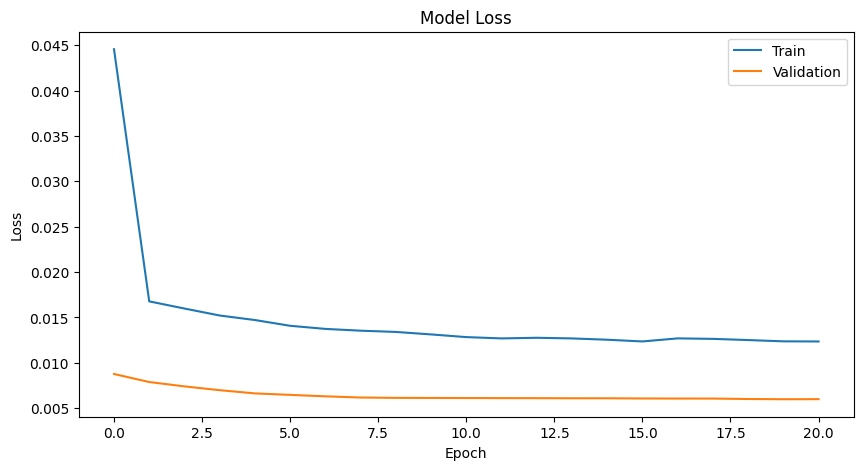

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Train MAE: 0.25378867239545005
Train MSE: 0.12334223538573601
Train RMSE: 0.351201132381056

Test MAE: 0.18879375549238037
Test MSE: 0.05915588705377316
Test RMSE: 0.24321983277227446


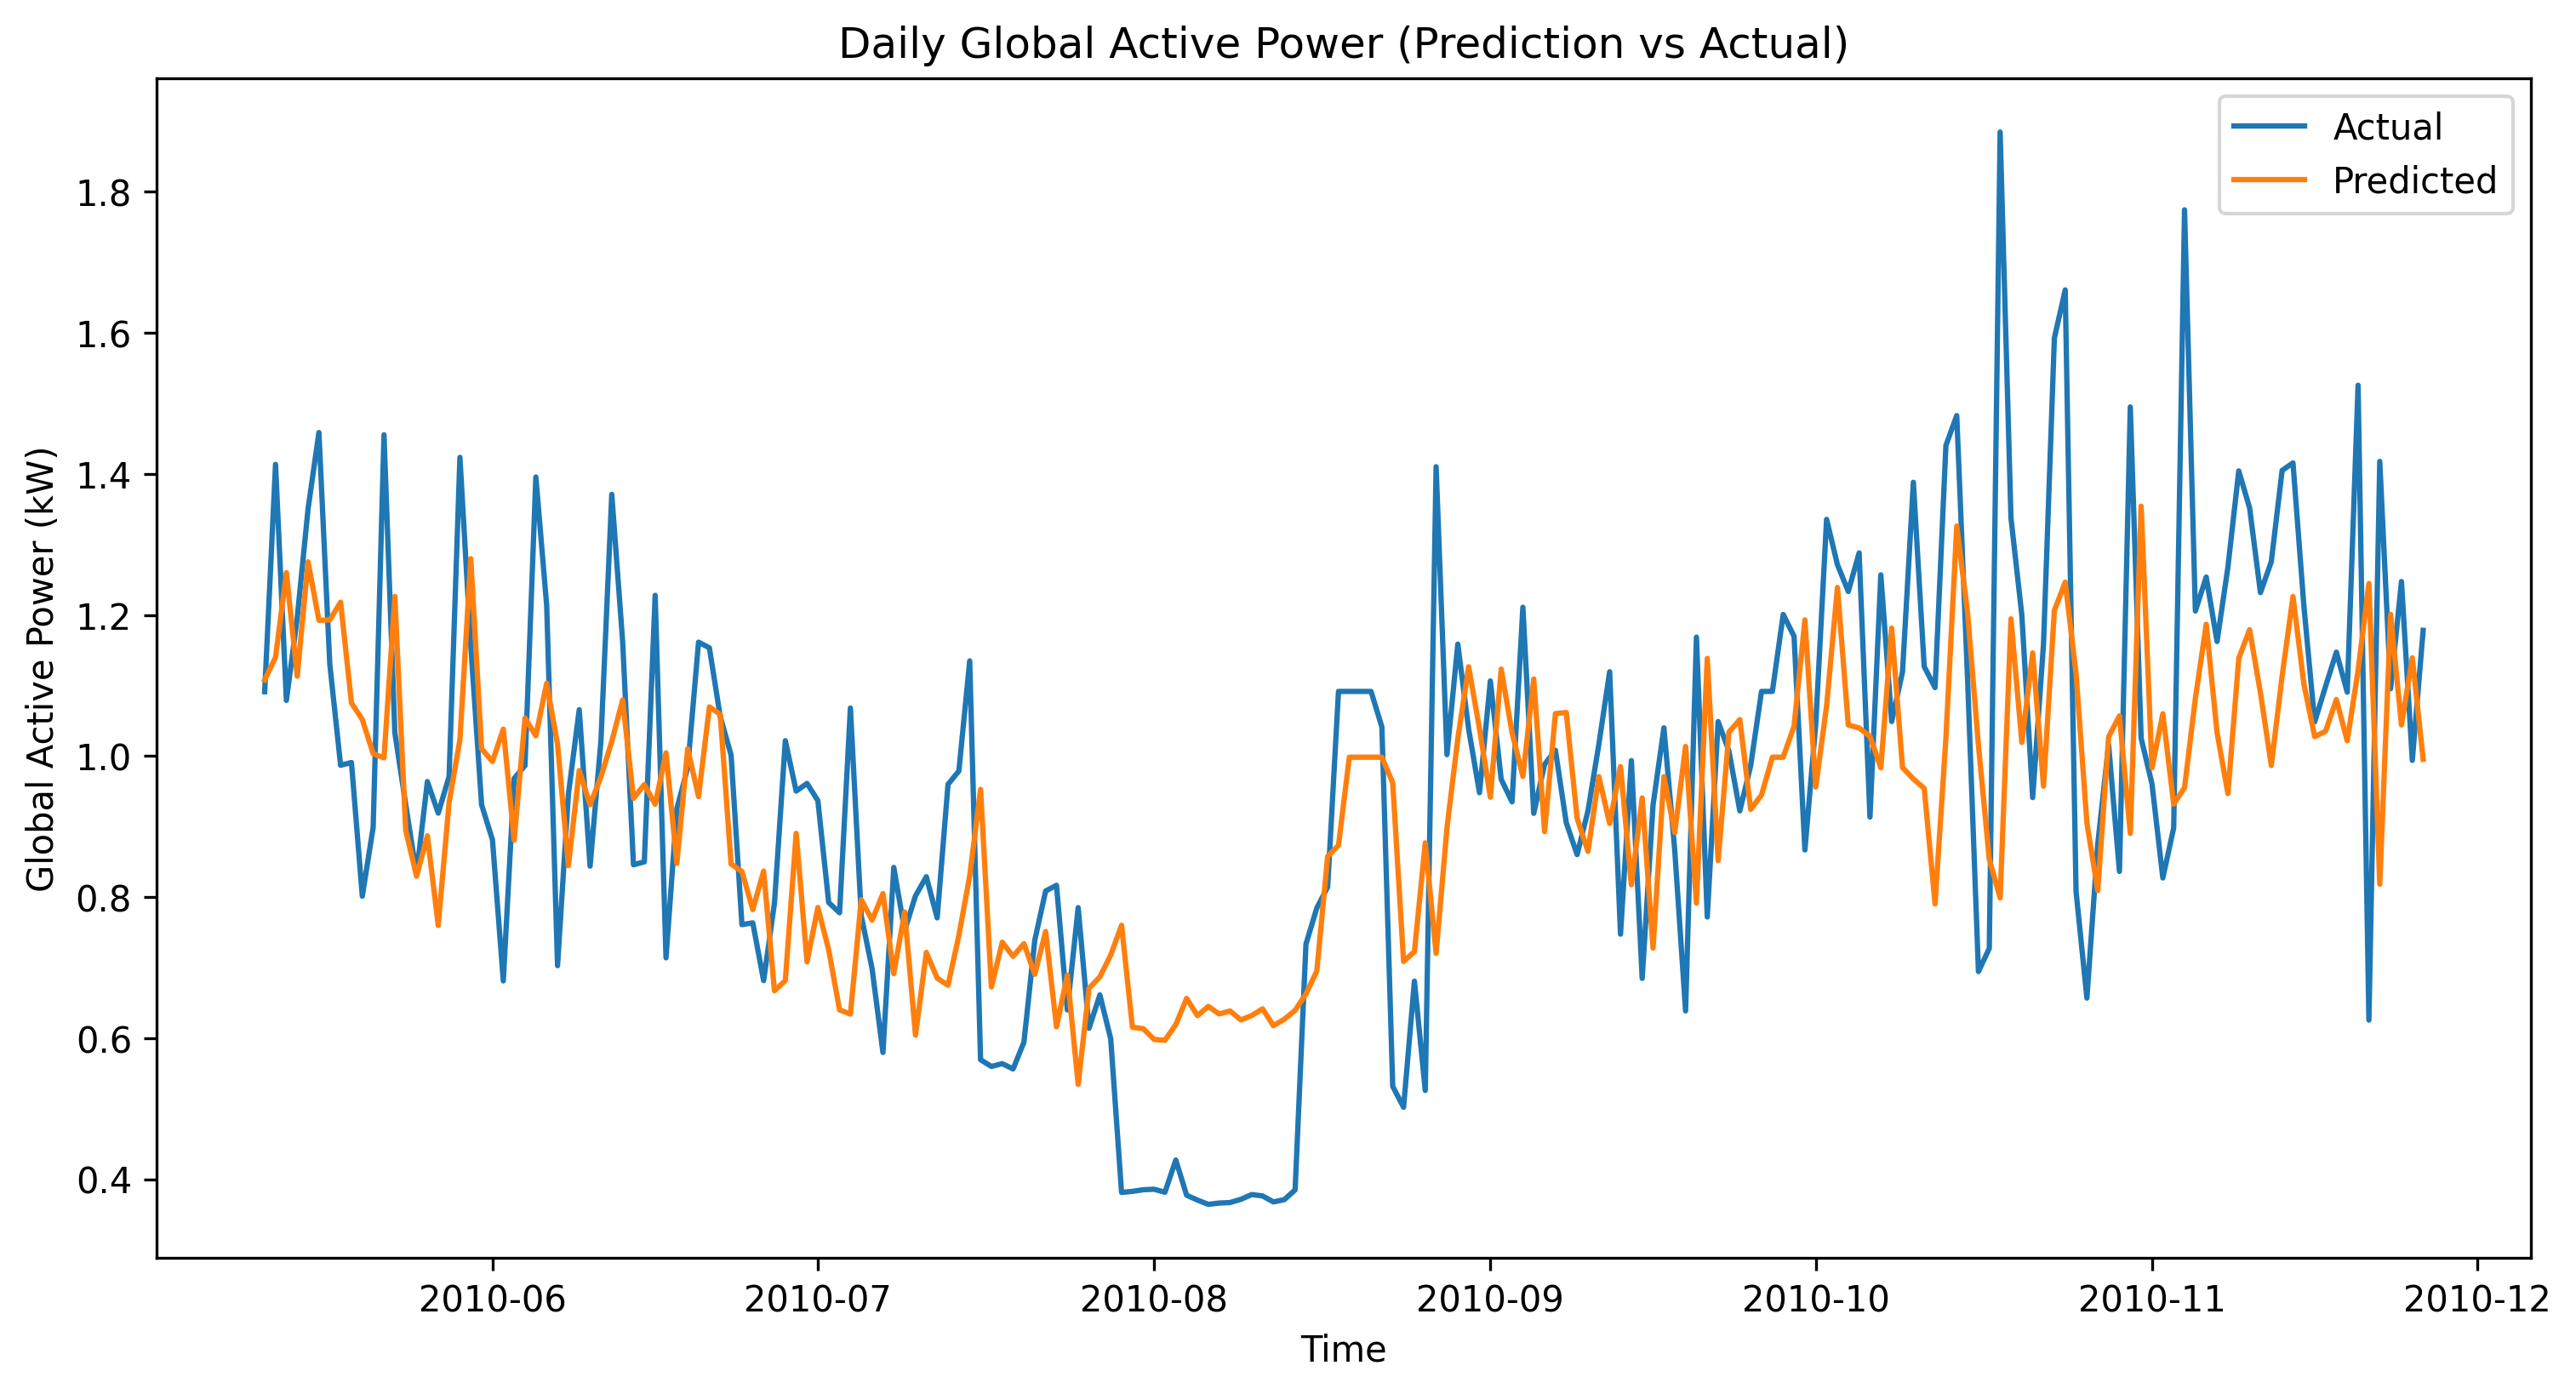

In [28]:
# Define sequence length and features
sequence_length = 1             # Number of time steps to consider in each sequence
num_features = len(df2.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df2) - sequence_length):
    seq = scaled_df2[i:i+sequence_length]
    label = scaled_df2[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Displaying a summary of the model
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20 , min_delta=0.005)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False, callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print('Train MAE:', mean_absolute_error(true_train_y, pred_train_y))
print('Train MSE:', mean_squared_error(true_train_y, pred_train_y))
print('Train RMSE:',np.sqrt(mean_squared_error(true_train_y, pred_train_y)))

print('\nTest MAE:', mean_absolute_error(true_test_y, pred_test_y))
print('Test MSE:', mean_squared_error(true_test_y, pred_test_y))
print('Test RMSE:',np.sqrt(mean_squared_error(true_test_y, pred_test_y)))

# Plotting predicted and actual temperatures
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df2.index[-200:], true_test_y[-200:], label='Actual')
plt.plot(df2.index[-200:], pred_test_y[-200:], label='Predicted')
plt.title('Daily Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

## LSTM-2 seq=7 epochs=50 batch_size=32

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
36/36 - 2s - 49ms/step - loss: 0.0356 - val_loss: 0.0063
Epoch 2/50
36/36 - 0s - 5ms/step - loss: 0.0146 - val_loss: 0.0059
Epoch 3/50
36/36 - 0s - 8ms/step - loss: 0.0132 - val_loss: 0.0060
Epoch 4/50
36/36 - 0s - 8ms/step - loss: 0.0124 - val_loss: 0.0060
Epoch 5/50
36/36 - 0s - 8ms/step - loss: 0.0118 - val_loss: 0.0061
Epoch 6/50
36/36 - 0s - 9ms/step - loss: 0.0117 - val_loss: 0.0059
Epoch 7/50
36/36 - 0s - 5ms/step - loss: 0.0116 - val_loss: 0.0059
Epoch 8/50
36/36 - 0s - 8ms/step - loss: 0.0115 - val_loss: 0.0057
Epoch 9/50
36/36 - 0s - 5ms/step - loss: 0.0113 - val_loss: 0.0057
Epoch 10/50
36/36 - 0s - 8ms/step - loss: 0.0114 - val_loss: 0.0058
Epoch 11/50
36/36 - 0s - 8ms/step - loss: 0.0113 - val_loss: 0.0057
Epoch 12/50
36/36 - 0s - 9ms/step - loss: 0.0111 - val_loss: 0.0055
Epoch 13/50
36/36 - 0s - 5ms/step - loss: 0.0111 - val_loss: 0.0055
Epoch 14/50
36/36 - 0s - 5ms/step - loss: 0.0108 - val_loss: 0.0054
Epoch 15/50
36/36 - 0s - 5ms/step - loss: 0.0111 - val_l

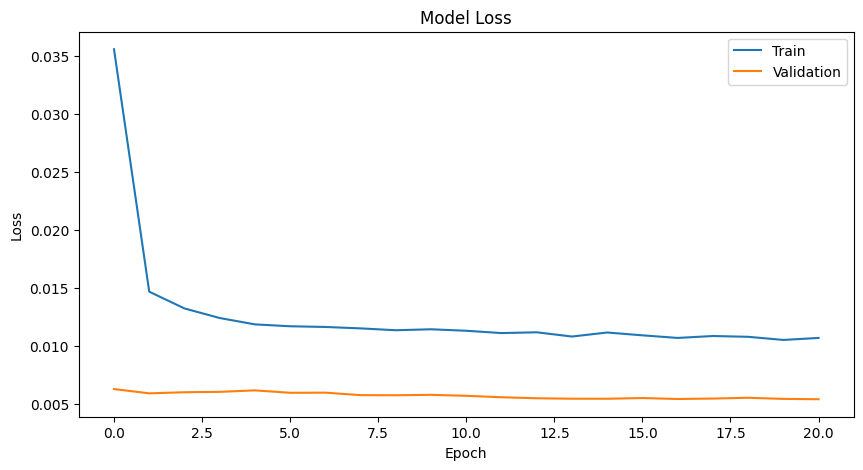

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train MAE: 0.23222459328506767
Train MSE: 0.09885403507228649
Train RMSE: 0.31441061539376575

Test MAE: 0.17264449047557603
Test MSE: 0.05304388013588333
Test RMSE: 0.23031257051208326


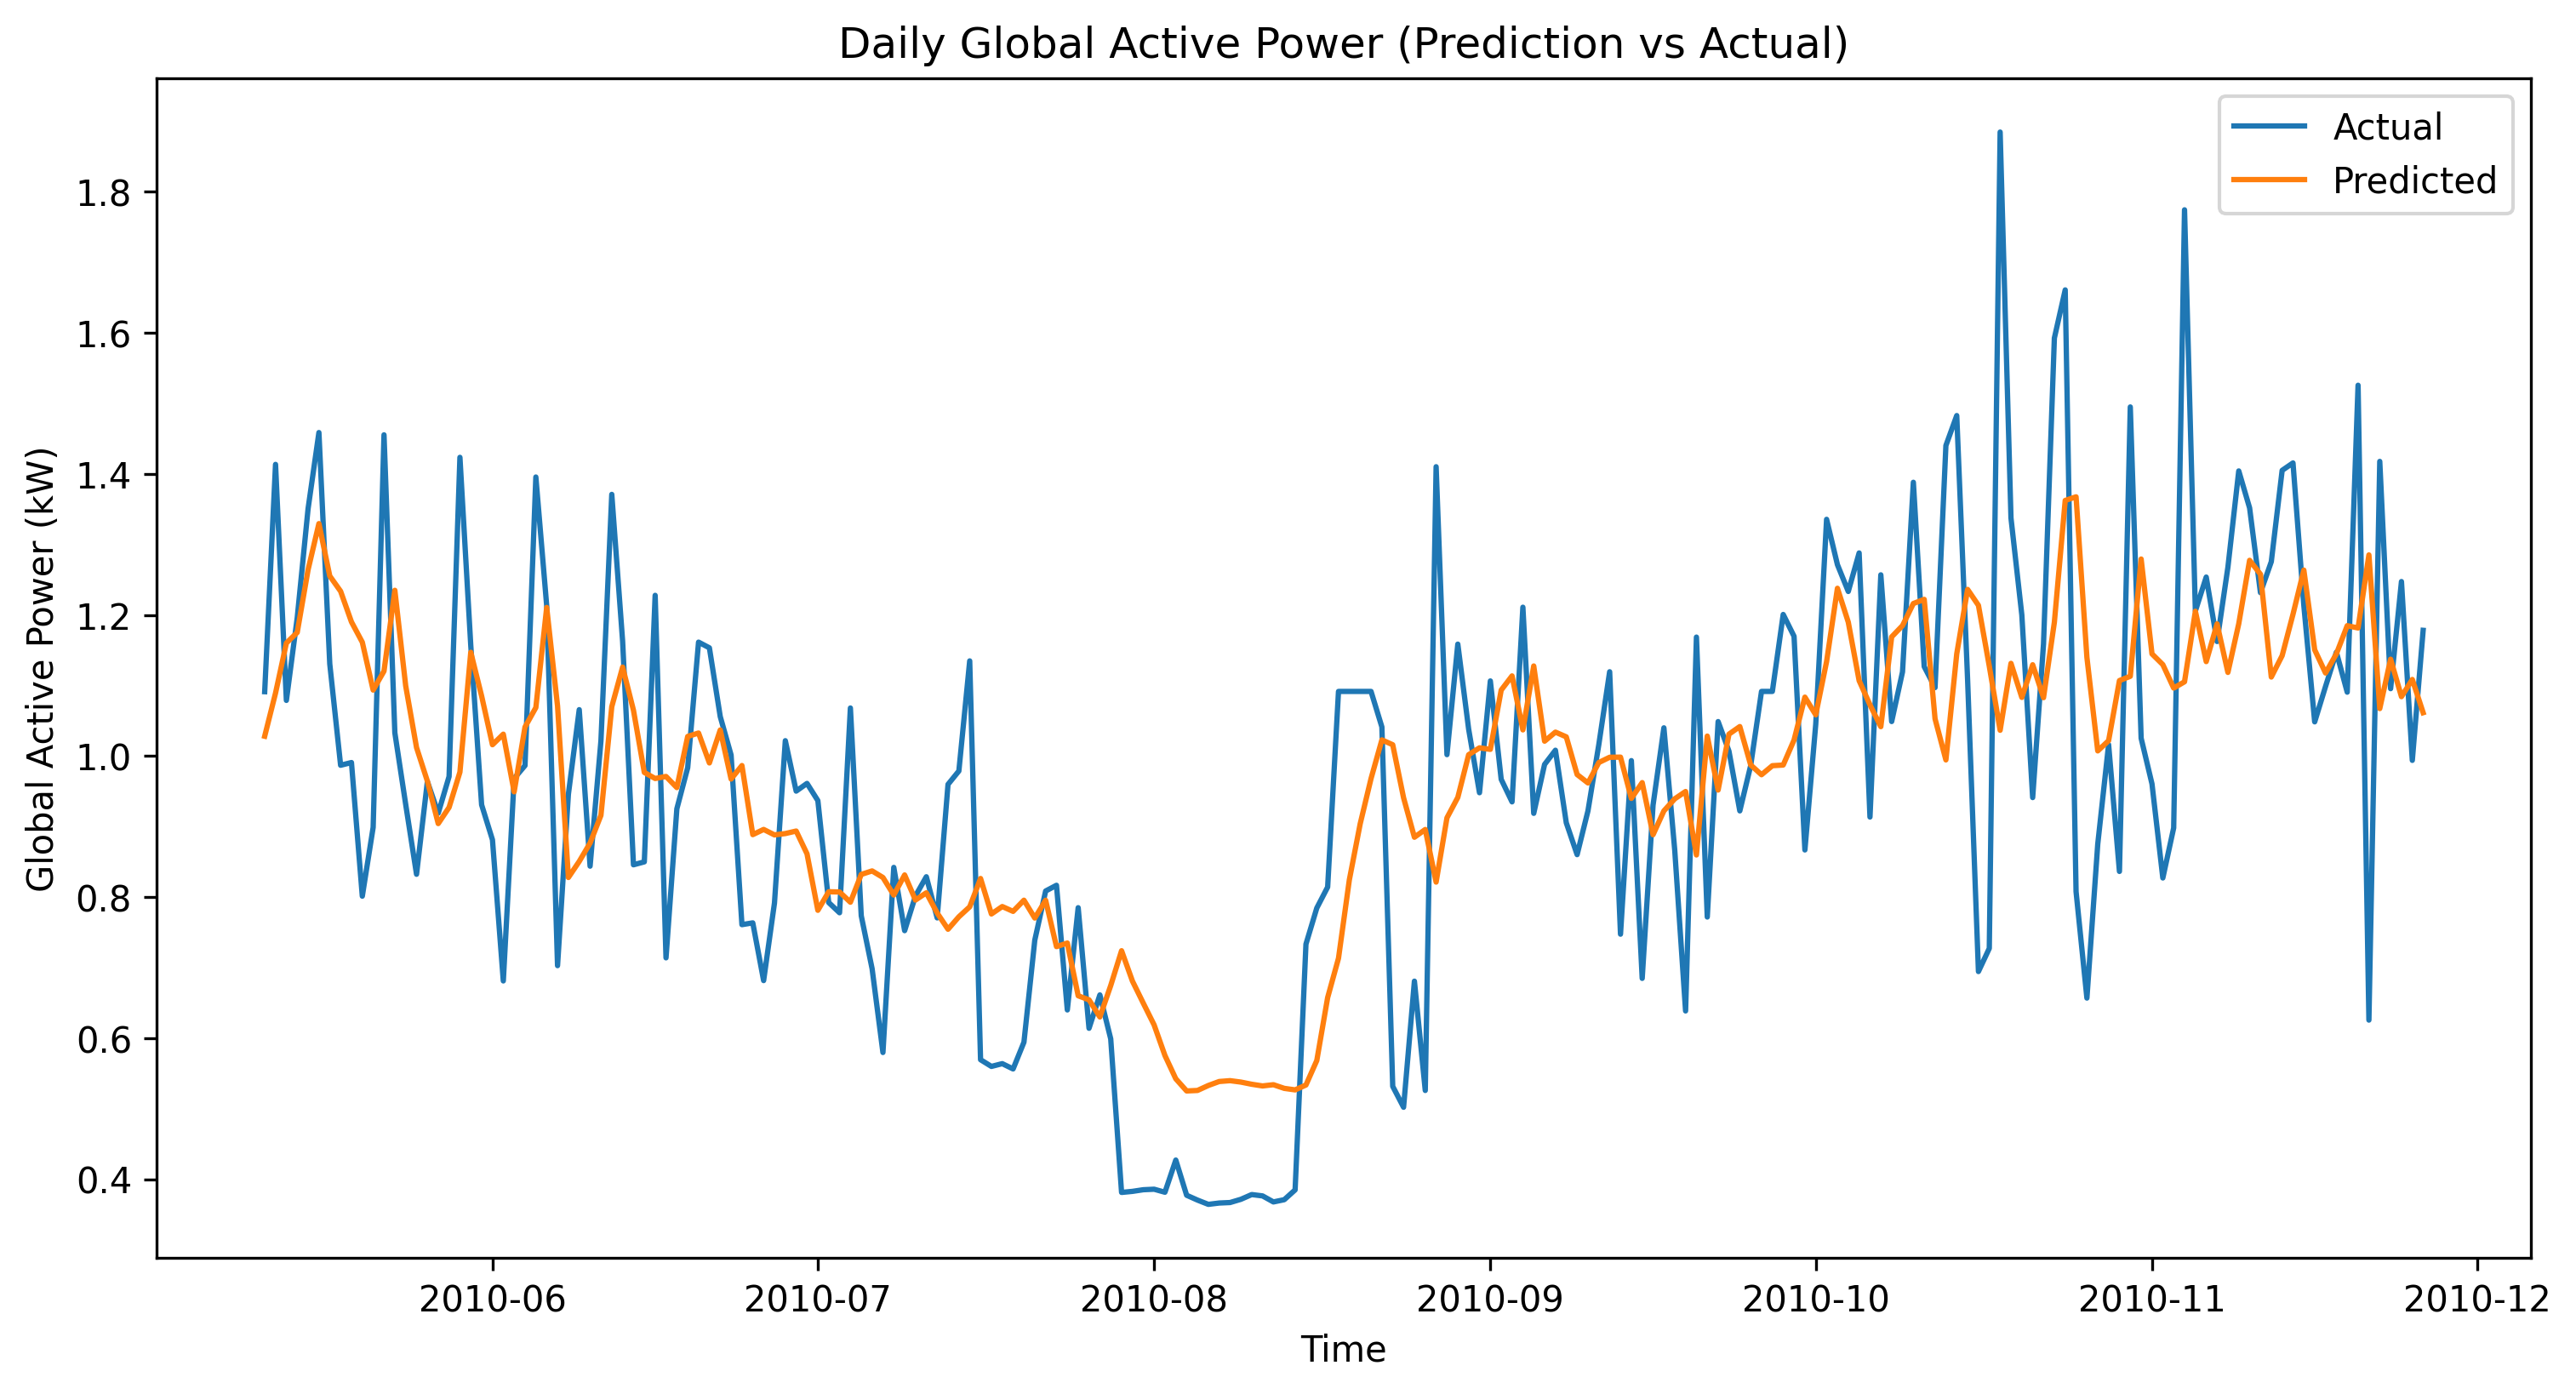

In [29]:
# Define sequence length and features
sequence_length = 7             # Number of time steps to consider in each sequence
num_features = len(df2.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df2) - sequence_length):
    seq = scaled_df2[i:i+sequence_length]
    label = scaled_df2[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Displaying a summary of the model
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20 , min_delta=0.005)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False, callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print('Train MAE:', mean_absolute_error(true_train_y, pred_train_y))
print('Train MSE:', mean_squared_error(true_train_y, pred_train_y))
print('Train RMSE:',np.sqrt(mean_squared_error(true_train_y, pred_train_y)))

print('\nTest MAE:', mean_absolute_error(true_test_y, pred_test_y))
print('Test MSE:', mean_squared_error(true_test_y, pred_test_y))
print('Test RMSE:',np.sqrt(mean_squared_error(true_test_y, pred_test_y)))

# Plotting predicted and actual temperatures
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df2.index[-200:], true_test_y[-200:], label='Actual')
plt.plot(df2.index[-200:], pred_test_y[-200:], label='Predicted')
plt.title('Daily Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

## LSTM-3 seq=30 epochs=50 batch_size=32

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
864/864 - 7s - 8ms/step - loss: 0.0128 - val_loss: 0.0101
Epoch 2/50
864/864 - 5s - 6ms/step - loss: 0.0095 - val_loss: 0.0096
Epoch 3/50
864/864 - 4s - 5ms/step - loss: 0.0088 - val_loss: 0.0096
Epoch 4/50
864/864 - 5s - 6ms/step - loss: 0.0085 - val_loss: 0.0090
Epoch 5/50
864/864 - 5s - 6ms/step - loss: 0.0083 - val_loss: 0.0087
Epoch 6/50
864/864 - 4s - 5ms/step - loss: 0.0081 - val_loss: 0.0085
Epoch 7/50
864/864 - 4s - 4ms/step - loss: 0.0080 - val_loss: 0.0087
Epoch 8/50
864/864 - 5s - 6ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 9/50
864/864 - 9s - 11ms/step - loss: 0.0078 - val_loss: 0.0081
Epoch 10/50
864/864 - 4s - 5ms/step - loss: 0.0077 - val_loss: 0.0081
Epoch 11/50
864/864 - 7s - 8ms/step - loss: 0.0077 - val_loss: 0.0080
Epoch 12/50
864/864 - 4s - 5ms/step - loss: 0.0076 - val_loss: 0.0082
Epoch 13/50
864/864 - 8s - 10ms/step - loss: 0.0076 - val_loss: 0.0080
Epoch 14/50
864/864 - 7s - 8ms/step - loss: 0.0075 - val_loss: 0.0077
Epoch 15/50
864/864 - 11s -

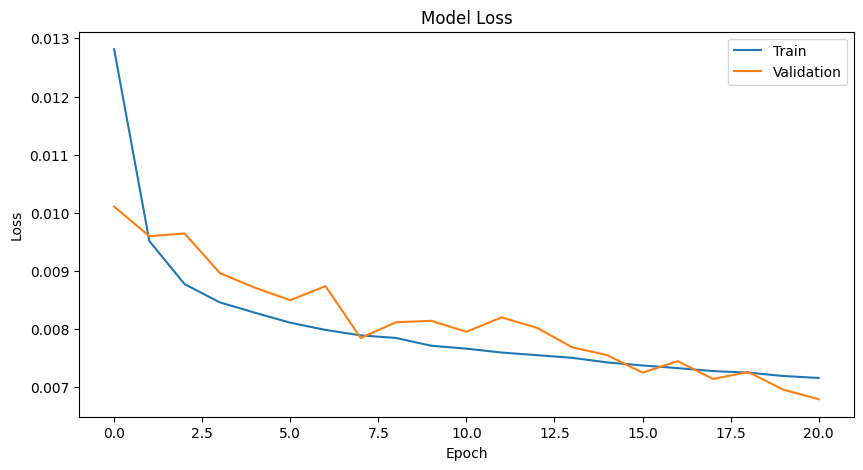

864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train MAE: 0.21811918077581718
Train MSE: 0.0833687137151015
Train RMSE: 0.28873640871061185

Test MAE: 0.19788760741234673
Test MSE: 0.06703058755165289
Test RMSE: 0.2589026603796355


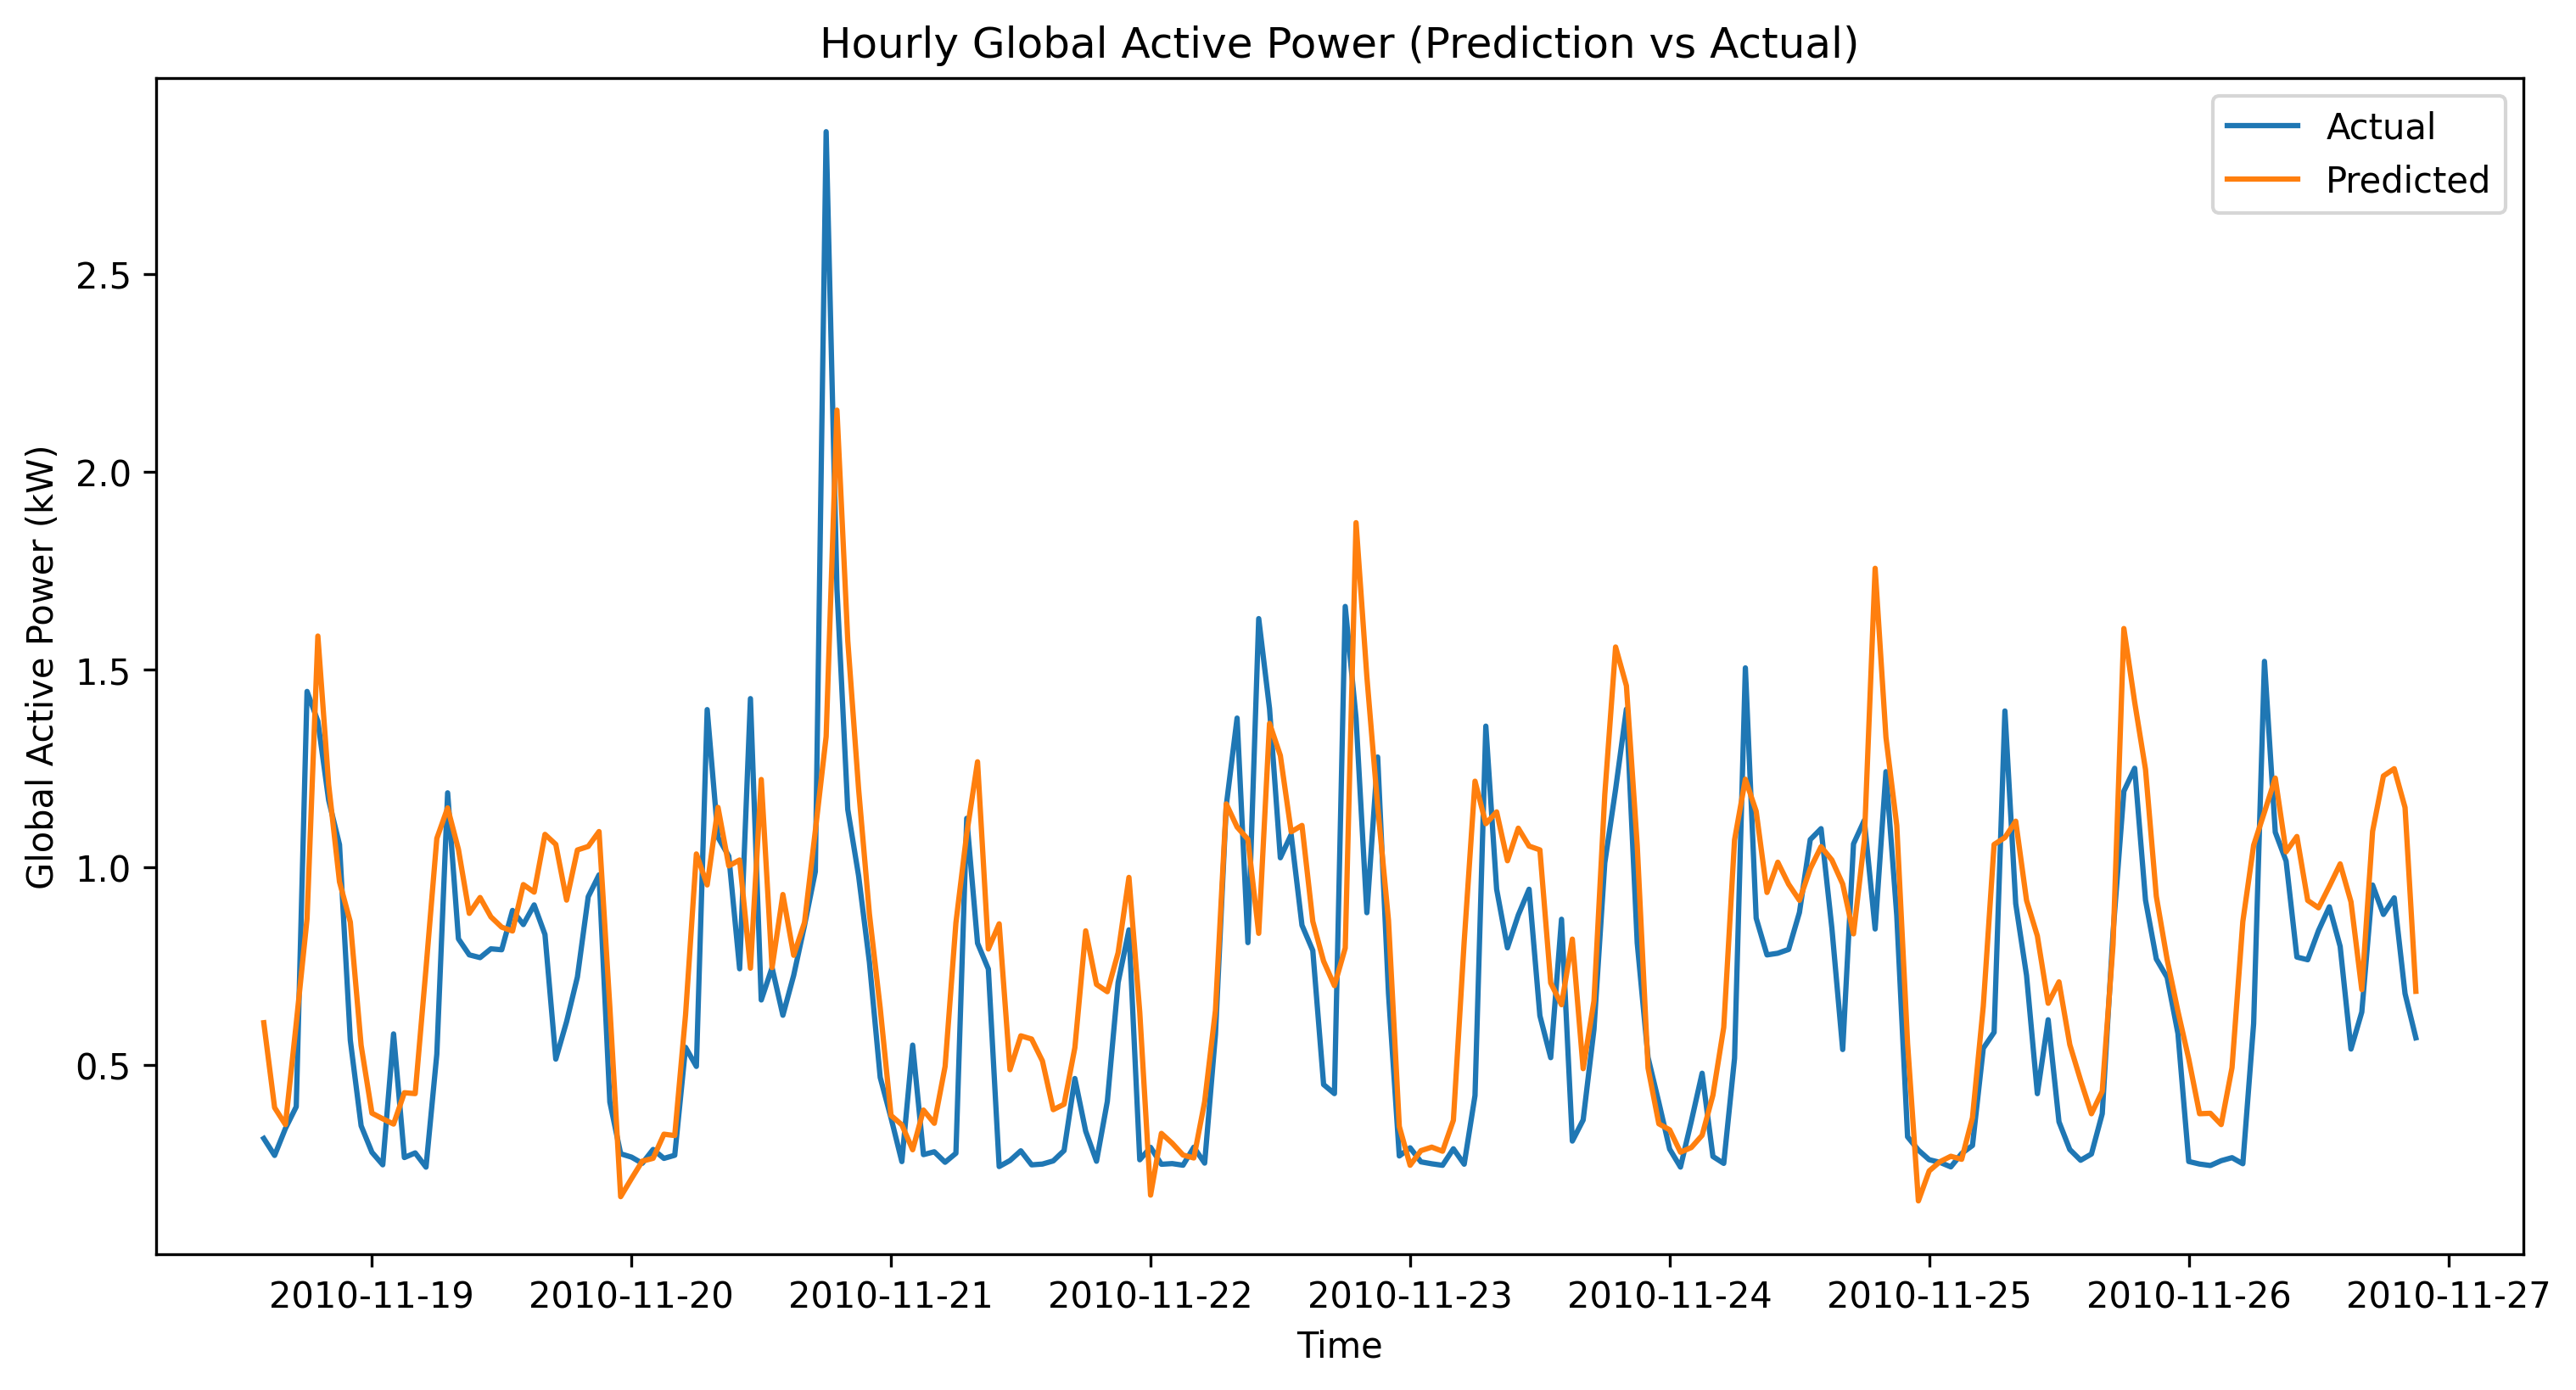

In [30]:
# Define sequence length and features
sequence_length = 30             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Displaying a summary of the model
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20 , min_delta=0.005)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False, callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print('Train MAE:', mean_absolute_error(true_train_y, pred_train_y))
print('Train MSE:', mean_squared_error(true_train_y, pred_train_y))
print('Train RMSE:',np.sqrt(mean_squared_error(true_train_y, pred_train_y)))

print('\nTest MAE:', mean_absolute_error(true_test_y, pred_test_y))
print('Test MSE:', mean_squared_error(true_test_y, pred_test_y))
print('Test RMSE:',np.sqrt(mean_squared_error(true_test_y, pred_test_y)))

# Plotting predicted and actual temperatures
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_test_y[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_test_y[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

## LSTM-4 seq=90 epochs=50 batch_size=32

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
864/864 - 7s - 8ms/step - loss: 0.0117 - val_loss: 0.0095
Epoch 2/50
864/864 - 8s - 10ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 3/50
864/864 - 5s - 6ms/step - loss: 0.0087 - val_loss: 0.0094
Epoch 4/50
864/864 - 4s - 5ms/step - loss: 0.0084 - val_loss: 0.0087
Epoch 5/50
864/864 - 5s - 5ms/step - loss: 0.0082 - val_loss: 0.0086
Epoch 6/50
864/864 - 4s - 5ms/step - loss: 0.0081 - val_loss: 0.0085
Epoch 7/50
864/864 - 5s - 6ms/step - loss: 0.0080 - val_loss: 0.0082
Epoch 8/50
864/864 - 4s - 4ms/step - loss: 0.0079 - val_loss: 0.0081
Epoch 9/50
864/864 - 4s - 4ms/step - loss: 0.0078 - val_loss: 0.0079
Epoch 10/50
864/864 - 5s - 6ms/step - loss: 0.0077 - val_loss: 0.0079
Epoch 11/50
864/864 - 9s - 10ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 12/50
864/864 - 7s - 8ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 13/50
864/864 - 7s - 8ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 14/50
864/864 - 5s - 5ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 15/50
864/864 - 5s - 

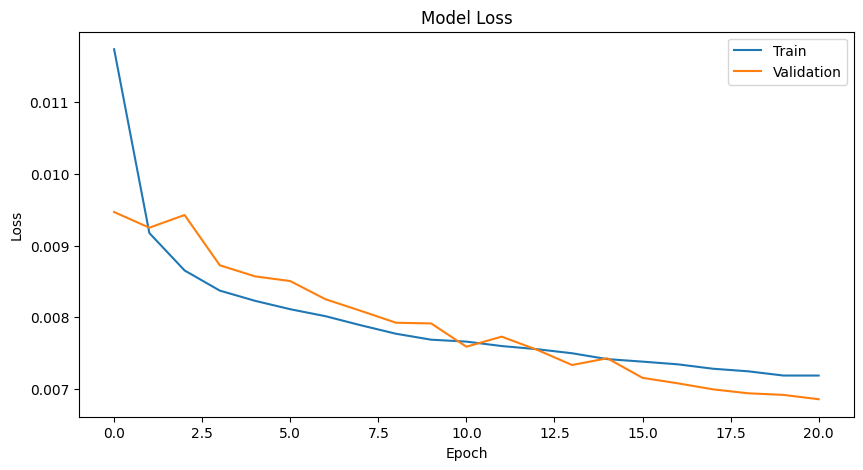

864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train MAE: 0.21682943625238582
Train MSE: 0.08207598474806173
Train RMSE: 0.2864890656692882

Test MAE: 0.1999396649019778
Test MSE: 0.06761672887706603
Test RMSE: 0.260032168927358


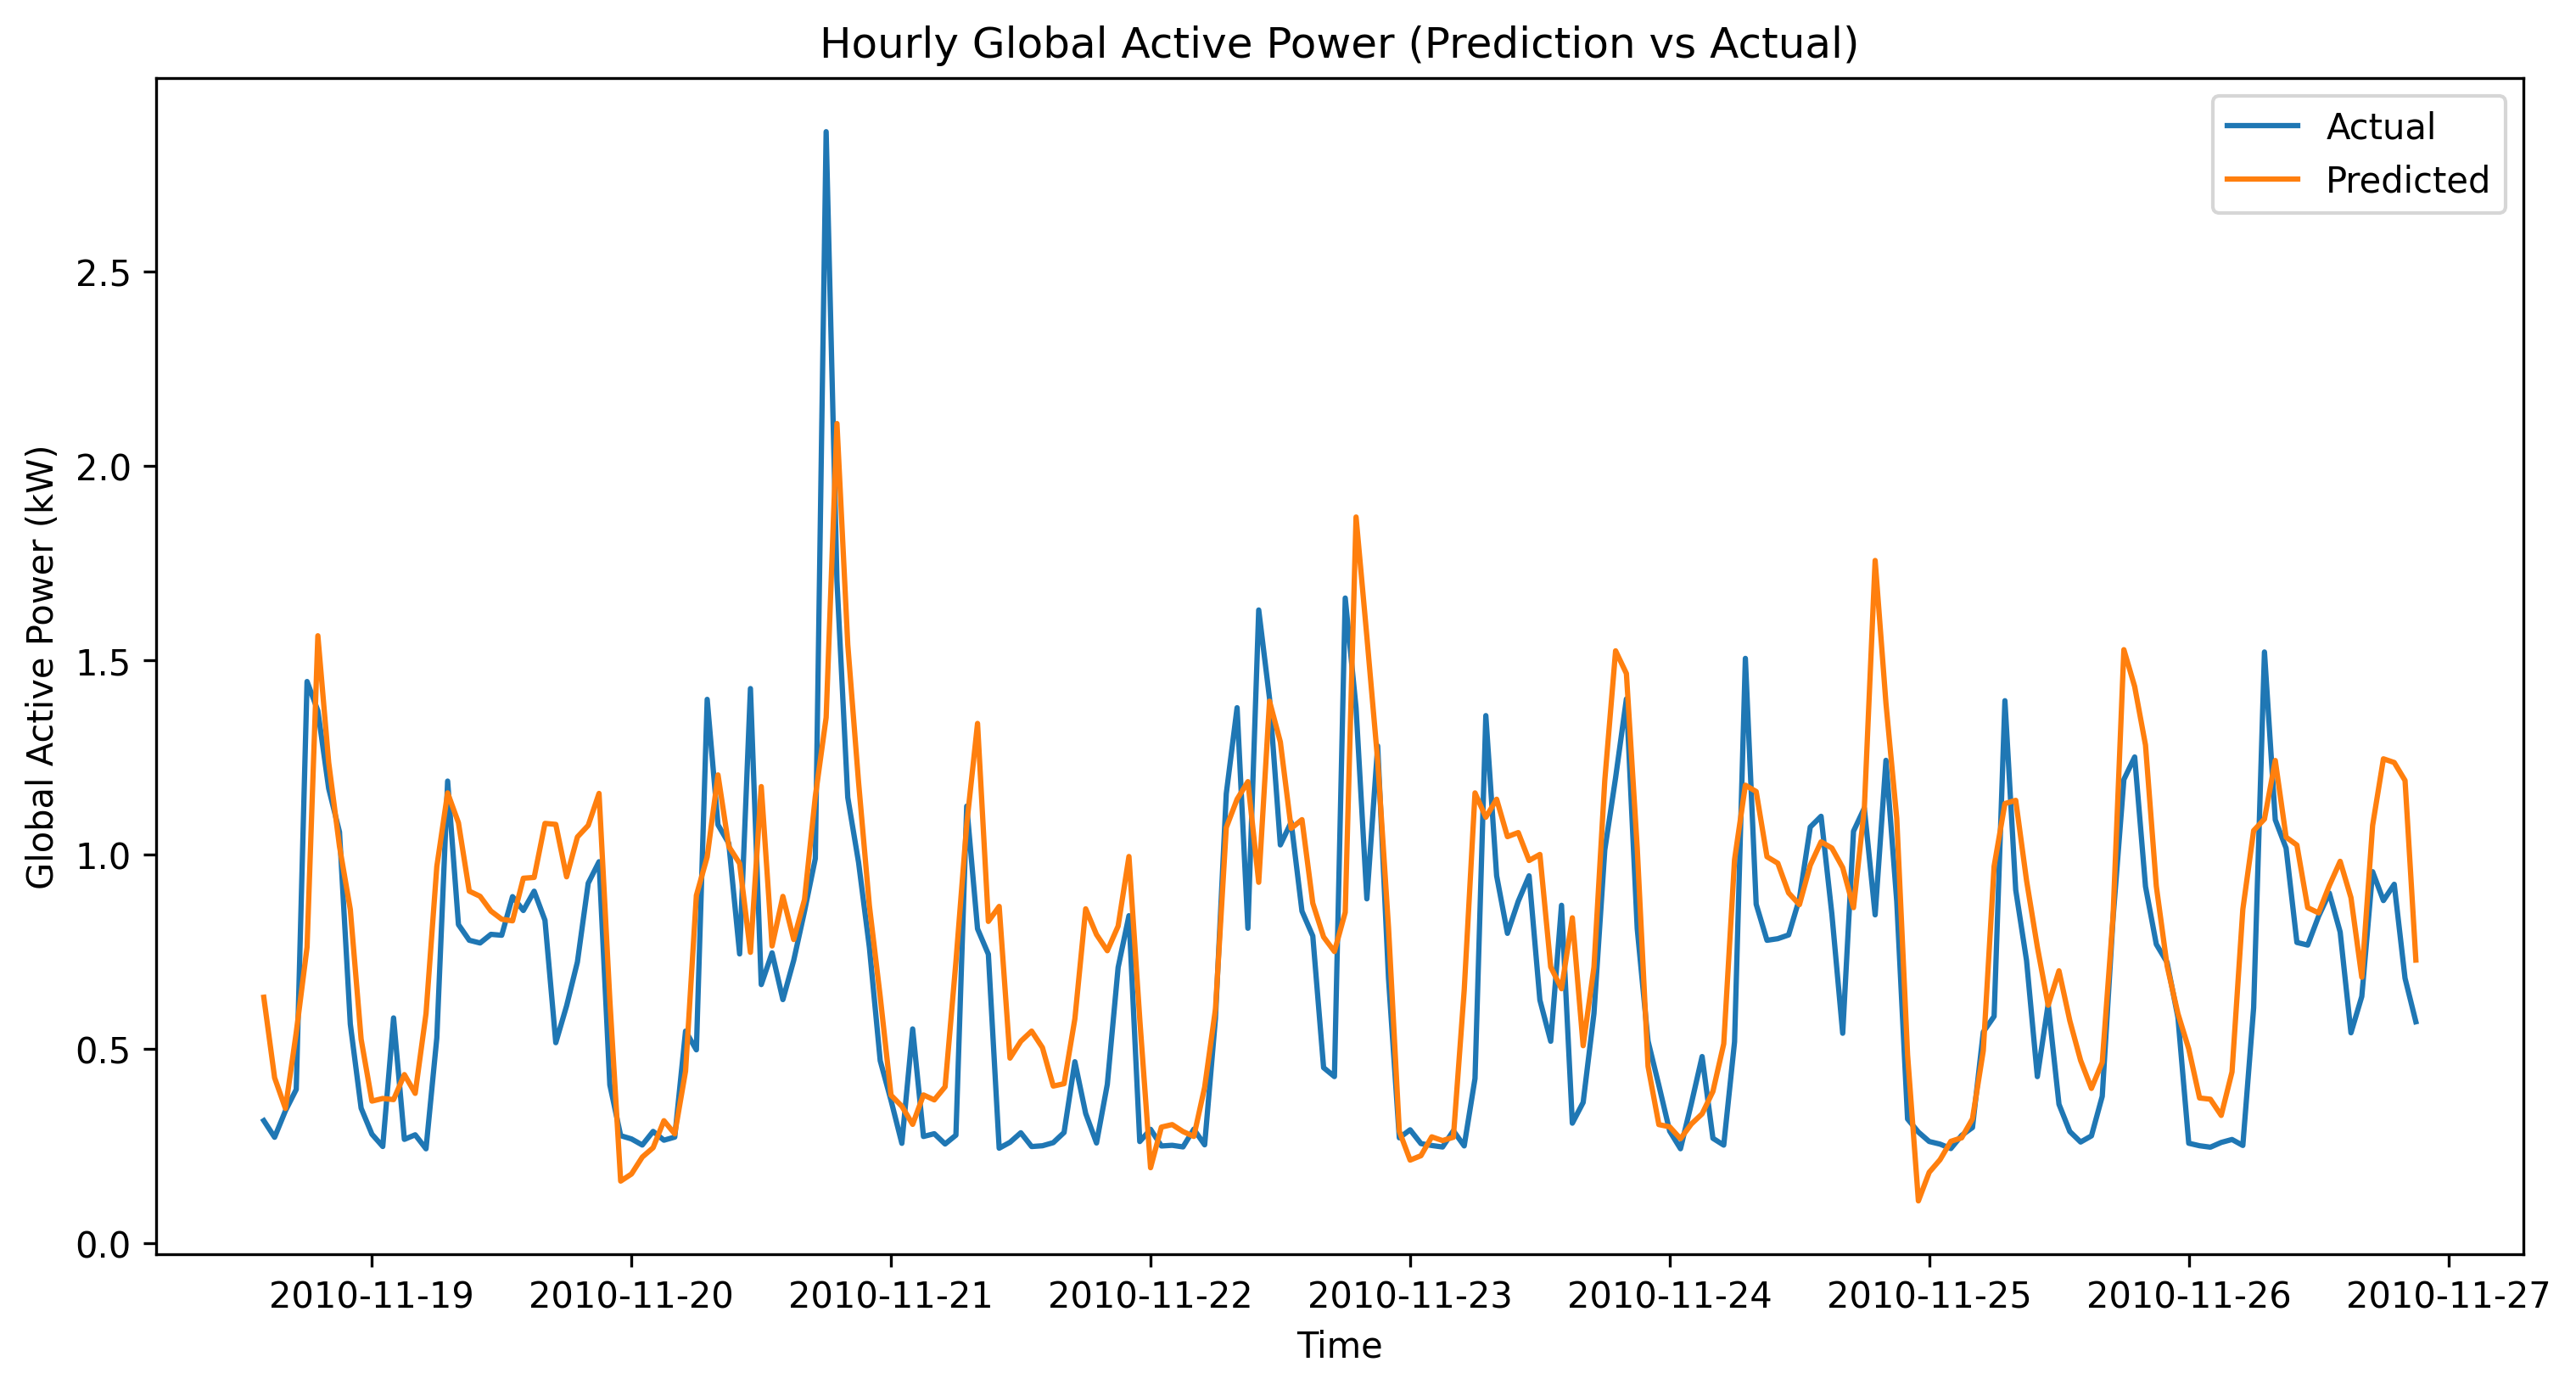

In [31]:
# Define sequence length and features
sequence_length = 30             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Displaying a summary of the model
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20 , min_delta=0.005)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False, callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print('Train MAE:', mean_absolute_error(true_train_y, pred_train_y))
print('Train MSE:', mean_squared_error(true_train_y, pred_train_y))
print('Train RMSE:',np.sqrt(mean_squared_error(true_train_y, pred_train_y)))

print('\nTest MAE:', mean_absolute_error(true_test_y, pred_test_y))
print('Test MSE:', mean_squared_error(true_test_y, pred_test_y))
print('Test RMSE:',np.sqrt(mean_squared_error(true_test_y, pred_test_y)))

# Plotting predicted and actual temperatures
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_test_y[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_test_y[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()